In [ ]:
!pip install Sastrawi
!pip install tqdm
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
from google.colab import drive
from wordcloud import WordCloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset FoodRecipe .csv')

**PREPROCESSING DATA**

In [ ]:
print("Number of rows in data =", df.shape[0])
print("Number of columns in data =", df.shape[1])
print("\n")

df.head(10)

Number of rows in data = 16000
Number of columns in data = 11




,No,FoodRecipe Name,Ingredient,Protein,Carbohydrate,Sodium,Fiber,Fat,Potassium,Cholesterol,Sugar
0,1,Ikan cod dan kerang littleneck,1½ pon ikan cod\n12 kerang leher kecil\nGaram ...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
1,2,Asparagus dengan Tarragon hangat,1½ pounds fresh asparagus 2 tablespoons balsa...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1
2,3,Udang karang Étouffe,"“1 batang seledri, cincang halus\n1 bawang bom...",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
3,4,Bass Pan Seared Renyah dengan Walnut Romesco d...,"""4 (4 hingga 6 ons) fillet ikan putih berkulit...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,5,Ikan Kreol,"¼ cup olive oil\n1 onion, finely chopped\n½ sw...",1.0,1.0,1.0,1.0,1.0,0.0,1.0,0
5,6,Salmon yang Diasinkan Miso Dipanggang di Atas ...,"1 pound salmon filet, skin-on\n¼ cup (4 tables...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,7,"Salmon Panggang dengan Dill, Minyak Zaitun, da...",4 skinless salmon fillets (5 ounces each)\n1/8...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1
7,8,Salmon Panggang Disajikan dengan Minty Snap Peas,"6 pieces salmon fillets with skin on, each wei...",1.0,1.0,0.0,1.0,1.0,0.0,1.0,1
8,9,Salad Adas Serut dengan Hamachi Berkulit Ketumbar,"3 heads of fennel, cored and sliced super thin...",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1
9,10,Gumbo Udang dan Ayam,2 cups chopped okra\n4 tablespoons sesame oil\...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1


In [ ]:
missing_values_check = df[['FoodRecipe Name', 'Ingredient']].isnull().sum()
print(missing_values_check)

FoodRecipe Name    54
Ingredient         89
dtype: int64


In [ ]:
# List of nutrients to check
nutrients = ['Protein', 'Carbohydrate', 'Sodium', 'Fiber', 'Fat', 'Potassium', 'Cholesterol', 'Sugar']

# Counting the non-null and non-zero values for each nutrient
nutrient_counts = {nutrient: df[(df[nutrient].notna()) & (df[nutrient] != 0)].shape[0] for nutrient in nutrients}

# Displaying the counts
for nutrient, count in nutrient_counts.items():
    print(f"Number of {nutrient} present in the dataset (excluding zeros): {count}")

Number of Protein present in the dataset (excluding zeros): 9313
Number of Carbohydrate present in the dataset (excluding zeros): 9106
Number of Sodium present in the dataset (excluding zeros): 9258
Number of Fiber present in the dataset (excluding zeros): 8885
Number of Fat present in the dataset (excluding zeros): 9085
Number of Potassium present in the dataset (excluding zeros): 9000
Number of Cholesterol present in the dataset (excluding zeros): 8991
Number of Sugar present in the dataset (excluding zeros): 9324


In [ ]:
df_cleaned = df.dropna(subset=['FoodRecipe Name', 'Ingredient', 'Carbohydrate'])

print("Data setelah menghapus baris yang memiliki nilai hilang di kolom 'FoodRecipe Name' dan 'Ingredient':\n", df_cleaned)

Data setelah menghapus baris yang memiliki nilai hilang di kolom 'FoodRecipe Name' dan 'Ingredient':
           No                                    FoodRecipe Name  \
0          1                     Ikan cod dan kerang littleneck   
1          2                   Asparagus dengan Tarragon hangat   
2          3                               Udang karang Étouffe   
3          4  Bass Pan Seared Renyah dengan Walnut Romesco d...   
4          5                                         Ikan Kreol   
...      ...                                                ...   
10041  10042                           Tahu Goreng Telur Simple   
10042  10043        Tahu telur beujeUkkkk (hancur)versi sundaan   
10125  10126                                       Lontong tahu   
10126  10127                                       Tahu Fantasi   
10127  10128                                   Pepes tahu jamur   

                                              Ingredient  Protein  \
0      1½ pon ikan cod\n

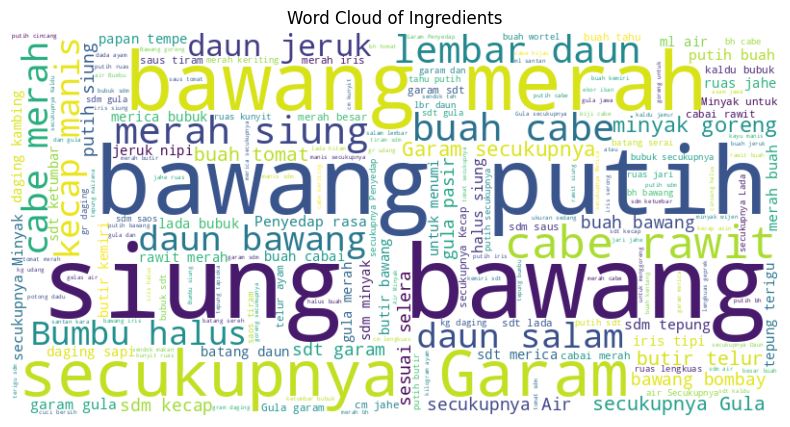

In [ ]:
# Replace NaN values with an empty string
df['Ingredient'] = df['Ingredient'].fillna("")

# Combine all text data from the Ingredient column for word cloud
all_ingredients = " ".join(df['Ingredient'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Ingredients')
plt.show()

In [ ]:
# Daftar kolom yang akan diubah
columns_to_replace = ['Protein', 'Carbohydrate', 'Sodium', 'Fiber', 'Fat', 'Potassium', 'Cholesterol', 'Sugar']

# Mengganti 'z' dengan NaN dan mengisi NaN dengan 0
df_cleaned[columns_to_replace] = df_cleaned[columns_to_replace].replace('z', np.nan).fillna(0)

# Menghilangkan nilai 11 dan 9 dari kolom Sodium dan Fiber
df_cleaned['Sodium'] = df_cleaned['Sodium'].replace([11], 0)
df_cleaned['Fiber'] = df_cleaned['Fiber'].replace([11, 9], 0)

# Mengonversi tipe data ke integer
df_cleaned[columns_to_replace] = df_cleaned[columns_to_replace].astype(int)

<ipython-input-12-ade4dff0f047>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[columns_to_replace] = df_cleaned[columns_to_replace].replace('z', np.nan).fillna(0)
<ipython-input-12-ade4dff0f047>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Sodium'] = df_cleaned['Sodium'].replace([11], 0)
<ipython-input-12-ade4dff0f047>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Inisialisasi stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# Definisikan stopword
stop_factory = StopWordRemoverFactory()
more_stopword = [
    'kilogram', 'kg', 'gram', 'g', 'gr', 'kecil', 'sedang', 'besar', 'sedikit', 'secukupnya', 'lembar',
    'lbr', 'siung', 'mangkok', 'ruas', 'piring', 'matang', 'btg', 'bh', 'masak', 'potong', 'ptng', 'masak',
    'cincang', 'iris', 'cuci', 'bersih', 'buah', 'buahnya', 'bungkus', 'bks', 'iris', 'serut', 'butir', 'biji', 'stgh',
]

df_stopword = stop_factory.get_stop_words() + more_stopword

def preprocess(s):
    s = re.sub(r'[^\w\s\d\n]', ' ', s)
    s = re.sub(r'\d+', ' ', s)

    hasil = []
    word_token = s.split()  # Menggunakan split() untuk tokenisasi
    unique_words = set()

    for word in word_token:
        word = word.strip().lower()
        if word not in df_stopword:
            word = stemmer.stem(word)
            if word not in unique_words:
                hasil.append(word)
                unique_words.add(word)
    result_sentence = " ".join(hasil).strip()
    return result_sentence


In [ ]:
df_cleaned['Ingredient'] = df_cleaned['Ingredient'].astype(str)

result_preprocess = []
for i, row in tqdm(df_cleaned.iterrows(), total=df_cleaned.shape[0]):
    result_preprocess.append(preprocess(row['Ingredient']))

print('Done!')


<ipython-input-14-8277060c7a32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Ingredient'] = df_cleaned['Ingredient'].astype(str)
100%|██████████| 9300/9300 [08:36<00:00, 18.02it/s]

Done!


In [ ]:
# Menambahkan kolom yang relevan untuk pemeriksaan nilai unik
df_cleaned['ingredients_clean'] = result_preprocess

# Pemeriksaan nilai unik
for column in columns_to_replace:
    unique_values = df_cleaned[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'Protein': [1 0]
Unique values in column 'Carbohydrate': [1 0]
Unique values in column 'Sodium': [1 0]
Unique values in column 'Fiber': [1 0]
Unique values in column 'Fat': [1 0]
Unique values in column 'Potassium': [0 1]
Unique values in column 'Cholesterol': [0 1]
Unique values in column 'Sugar': [0 1]


<ipython-input-15-08ad10203851>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['ingredients_clean'] = result_preprocess


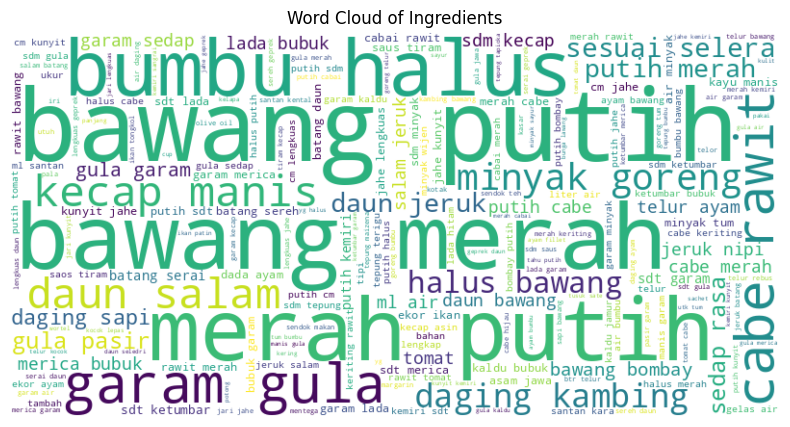

In [ ]:
# Membuat word cloud dari kolom ingredients_clean
all_ingredients = " ".join(df_cleaned['ingredients_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)

# Menampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Ingredients')
plt.show()

In [ ]:
df_cleaned

,No,FoodRecipe Name,Ingredient,Protein,Carbohydrate,Sodium,Fiber,Fat,Potassium,Cholesterol,Sugar,ingredients_clean
0,1,Ikan cod dan kerang littleneck,1½ pon ikan cod\n12 kerang leher kecil\nGaram ...,1,1,1,1,1,0,0,0,pon ikan cod kerang leher garam merica saus al...
1,2,Asparagus dengan Tarragon hangat,1½ pounds fresh asparagus 2 tablespoons balsa...,1,1,1,1,1,0,0,1,pounds fresh asparagus tablespoons balsamic vi...
2,3,Udang karang Étouffe,"“1 batang seledri, cincang halus\n1 bawang bom...",1,1,1,1,1,0,0,0,batang seledri halus bawang bombay paprika hij...
3,4,Bass Pan Seared Renyah dengan Walnut Romesco d...,"""4 (4 hingga 6 ons) fillet ikan putih berkulit...",1,1,1,1,1,1,0,1,hingga ons fillet ikan putih kulit tebal inci...
4,5,Ikan Kreol,"¼ cup olive oil\n1 onion, finely chopped\n½ sw...",1,1,1,1,1,0,1,0,cup olive oil onion finely chopped sweet green...
...,...,...,...,...,...,...,...,...,...,...,...,...
10041,10042,Tahu Goreng Telur Simple,Tahu putih \n1 butir telur\nGaram dan ladaku\n...,1,1,1,0,1,1,1,1,tahu putih telur garam lada olive oil canola
10042,10043,Tahu telur beujeUkkkk (hancur)versi sundaan,1 o ptong tahu.mau yng putih/kuning tergantung...,1,1,1,1,1,1,1,1,o ptong tahu mau yng putih kuning gantung sele...
10125,10126,Lontong tahu,2 Lontong bungkus daun pisang\n1 Cabe rawit\n3...,1,1,1,1,1,1,0,1,lontong daun pisang cabe rawit sdm kacang tana...
10126,10127,Tahu Fantasi,400 gr tahu \n1 buah wortel\n1 keping bihun\n1...,1,1,1,1,1,1,1,0,tahu wortel keping bihun tangkai daun bawang s...


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Menghitung TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['ingredients_clean'])
Y = df_cleaned[['Carbohydrate', 'Protein', 'Sodium', 'Fiber', 'Fat', 'Potassium', 'Cholesterol', 'Sugar']]

# Memisahkan data menjadi training dan testing set
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.3, random_state=42)


In [ ]:
# Oversampling pada training set menggunakan RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled = X_train
Y_train_resampled = pd.DataFrame()

for column in Y_train.columns:
    X_resampled, y_resampled = ros.fit_resample(X_train, Y_train[column])
    if Y_train_resampled.empty:
        X_train_resampled = X_resampled
        Y_train_resampled = pd.DataFrame(y_resampled, columns=[column])
    else:
        Y_train_resampled[column] = y_resampled

# Mengisi nilai NaN dengan mode dari setiap kolom
Y_train_resampled = Y_train_resampled.apply(lambda x: x.fillna(x.mode()[0]))

# Fungsi untuk menghitung overall accuracy
def calculate_overall_accuracy(Y_true, Y_pred):
    return (Y_pred == Y_true).mean().mean()

**Random Forest**

In [ ]:
# Inisialisasi model Random Forest dengan MultiOutputClassifier
rf = RandomForestClassifier(random_state=42)
multi_target_forest = MultiOutputClassifier(rf, n_jobs=-1)

# Melatih model
multi_target_forest.fit(X_train_resampled, Y_train_resampled)

# Memprediksi hasil pada testing set
Y_pred = multi_target_forest.predict(X_test)

# Menghasilkan laporan klasifikasi dan akurasi untuk setiap target
for i, column in enumerate(Y_test.columns):
    print(f"Classification Report for Random Forest - {column}:")
    print(classification_report(Y_test[column], Y_pred[:, i], zero_division=0))
    print(f"Accuracy for Random Forest - {column}: {accuracy_score(Y_test[column], Y_pred[:, i])}")
    print("-" * 50)

# Menghitung dan mencetak akurasi keseluruhan untuk Random Forest
overall_accuracy_rf = accuracy_score(Y_test.values.ravel(), Y_pred.ravel())
print(f"Overall Accuracy for Random Forest: {overall_accuracy_rf:.4f}")

Classification Report for Random Forest - Carbohydrate:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.98      1.00      0.99      2726

    accuracy                           0.98      2790
   macro avg       0.49      0.50      0.49      2790
weighted avg       0.95      0.98      0.97      2790

Accuracy for Random Forest - Carbohydrate: 0.9759856630824373
--------------------------------------------------
Classification Report for Random Forest - Protein:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      1.00      1.00      2785

    accuracy                           1.00      2790
   macro avg       0.50      0.50      0.50      2790
weighted avg       1.00      1.00      1.00      2790

Accuracy for Random Forest - Protein: 0.9971326164874552
--------------------------------------------------
Classification Rep

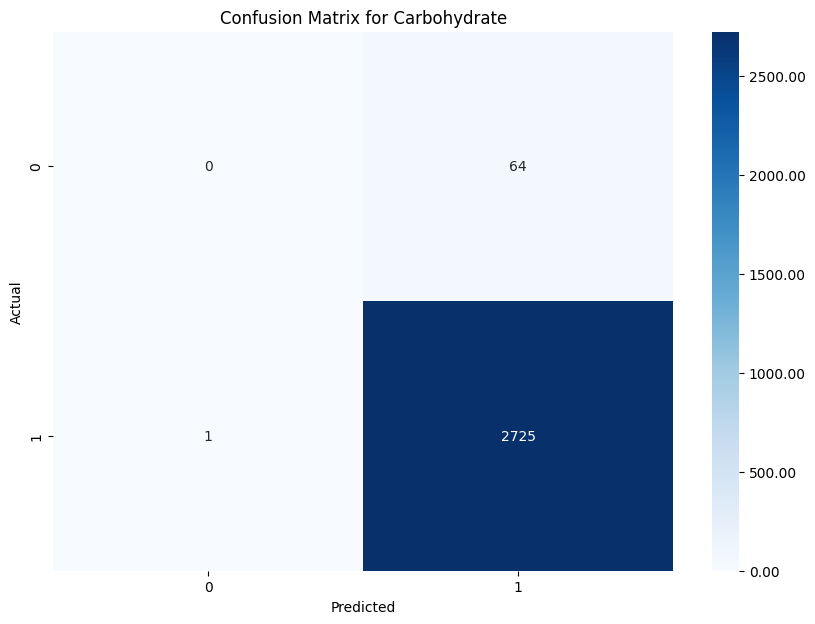

Nutrient: Carbohydrate
  Accuracy: 0.9767
  Precision: 0.4885
  Recall: 0.4998
  F1-score: 0.4941



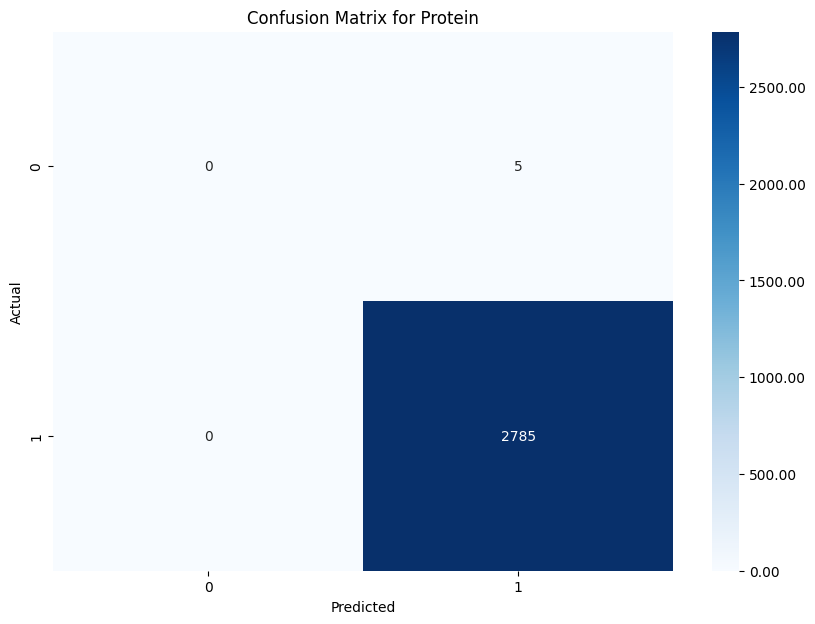

Nutrient: Protein
  Accuracy: 0.9982
  Precision: 0.4991
  Recall: 0.5000
  F1-score: 0.4996



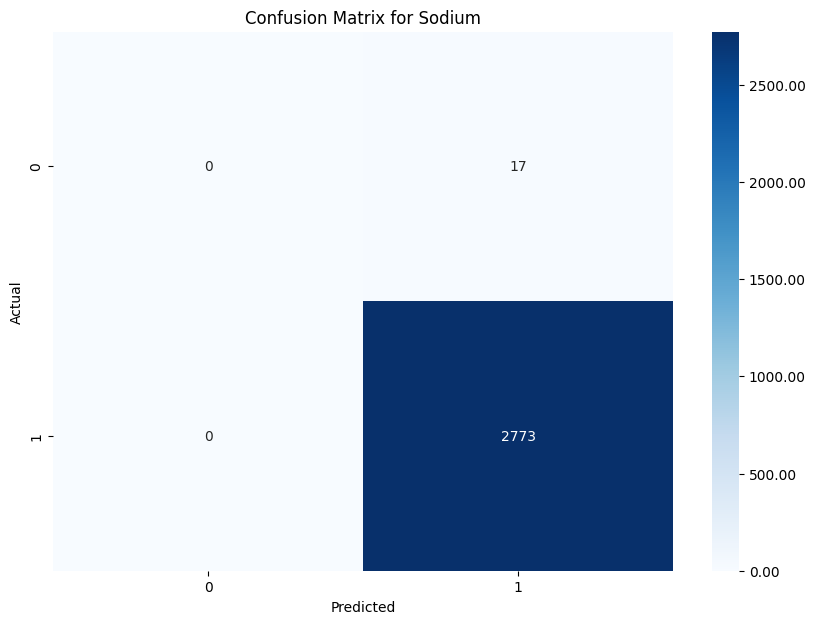

Nutrient: Sodium
  Accuracy: 0.9939
  Precision: 0.4970
  Recall: 0.5000
  F1-score: 0.4985



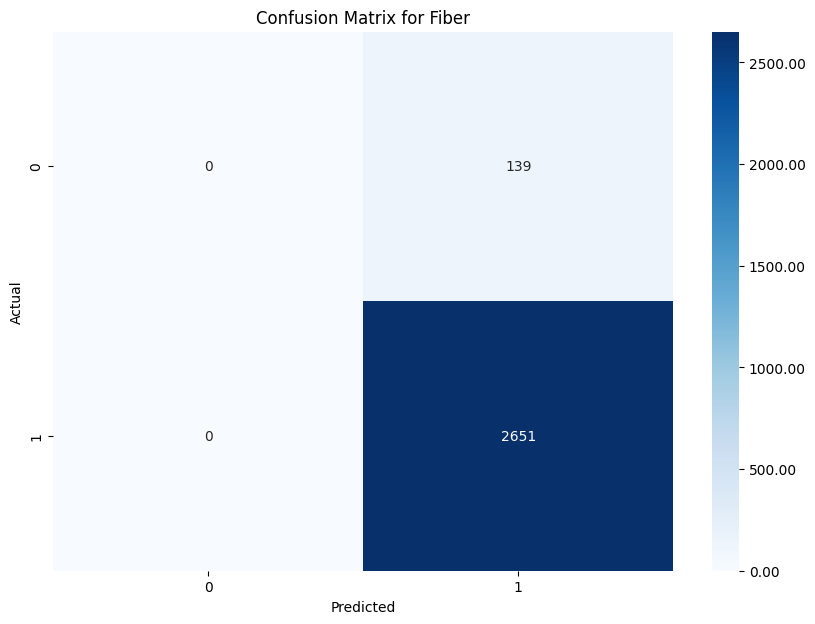

Nutrient: Fiber
  Accuracy: 0.9502
  Precision: 0.4751
  Recall: 0.5000
  F1-score: 0.4872



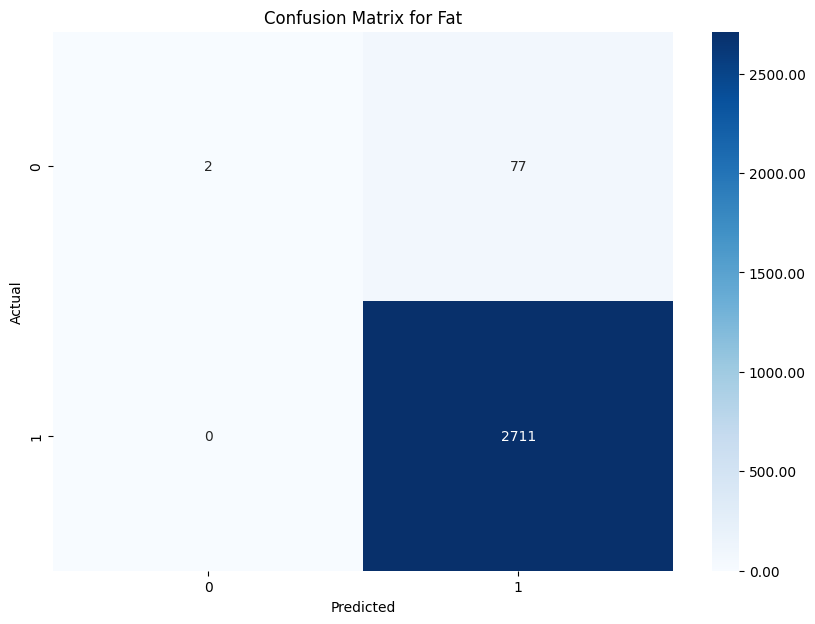

Nutrient: Fat
  Accuracy: 0.9724
  Precision: 0.9862
  Recall: 0.5127
  F1-score: 0.5177



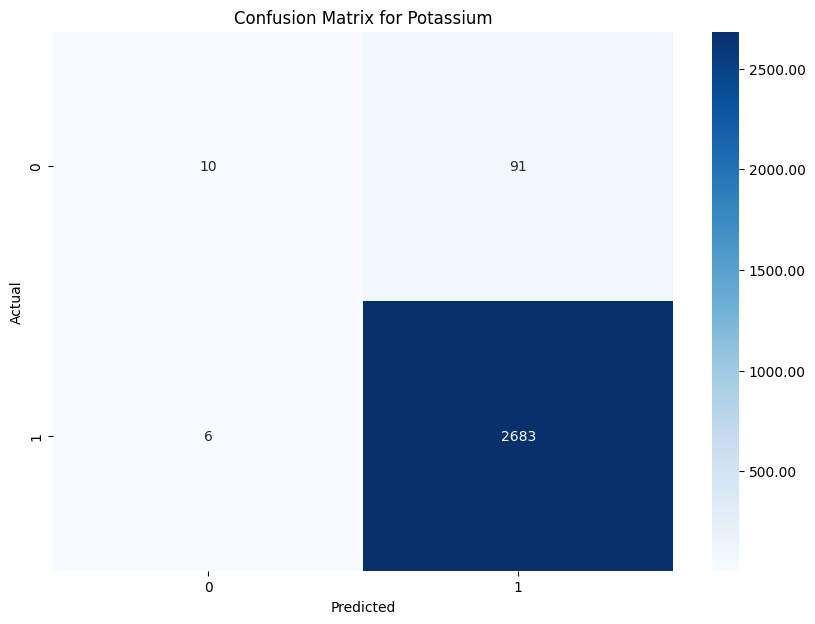

Nutrient: Potassium
  Accuracy: 0.9652
  Precision: 0.7961
  Recall: 0.5484
  F1-score: 0.5766



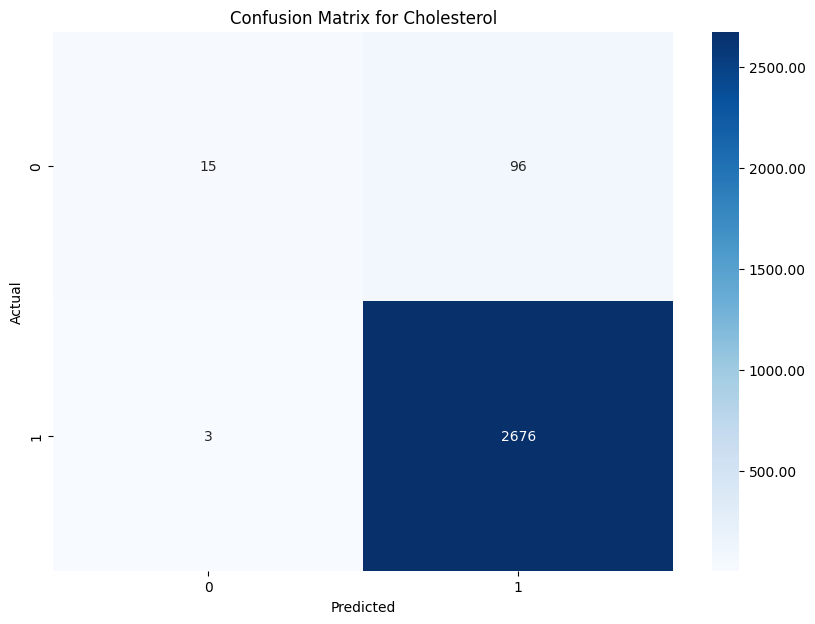

Nutrient: Cholesterol
  Accuracy: 0.9645
  Precision: 0.8994
  Recall: 0.5670
  F1-score: 0.6072



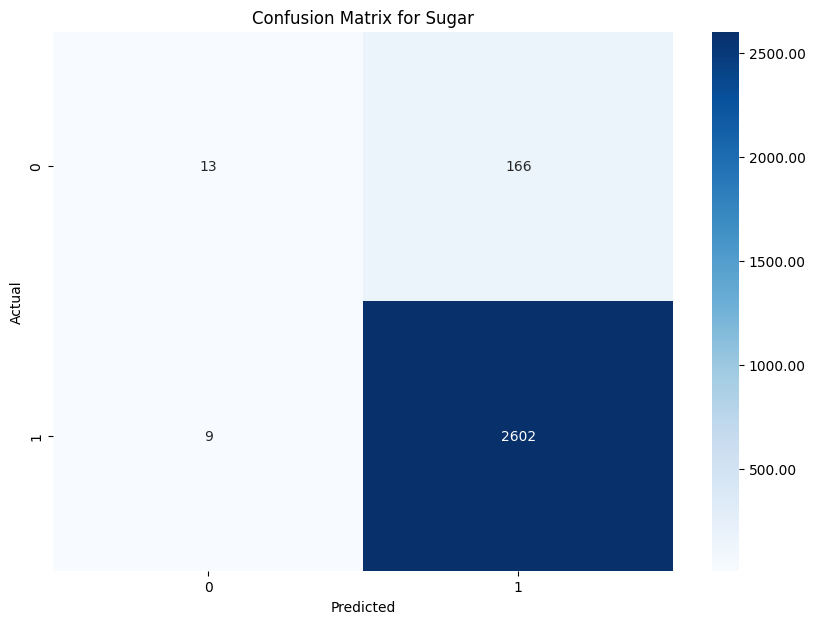

Nutrient: Sugar
  Accuracy: 0.9373
  Precision: 0.7655
  Recall: 0.5346
  F1-score: 0.5484

Average Scores:
Average Accuracy: 0.9698
Average Precision: 0.6758
Average Recall: 0.5203
Average F1-score: 0.5287


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np

# Skor yang ingin dievaluasi
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Collect results
results = {}
conf_matrices = {}

for i, column in enumerate(Y_test.columns):  # Assuming Y_test has the same columns as Y_train
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in cv.split(X_test, Y_test.iloc[:, i]):
        rf.fit(X_test[train_index], Y_test.iloc[train_index, i])
        y_true_fold = Y_test.iloc[test_index, i]
        y_pred_fold = rf.predict(X_test[test_index])

        y_true_all.extend(y_true_fold)
        y_pred_all.extend(y_pred_fold)

    # Compute confusion matrix for the current column
    cm = confusion_matrix(y_true_all, y_pred_all)
    conf_matrices[column] = cm

    # Calculate scores
    accuracy = accuracy_score(y_true_all, y_pred_all)
    precision = precision_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    recall = recall_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)

    # Store results
    results[column] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    # Plot the confusion matrix with correct precision
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.4g', cmap='Blues', cbar_kws={'format': '%.2f'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {column}')
    plt.show()

    # Print metrics for each nutrient
    print(f"Nutrient: {column}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print("")

# Print average scores
print("Average Scores:")
avg_accuracy = np.mean([metrics['accuracy'] for metrics in results.values()])
avg_precision = np.mean([metrics['precision'] for metrics in results.values()])
avg_recall = np.mean([metrics['recall'] for metrics in results.values()])
avg_f1 = np.mean([metrics['f1'] for metrics in results.values()])
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits


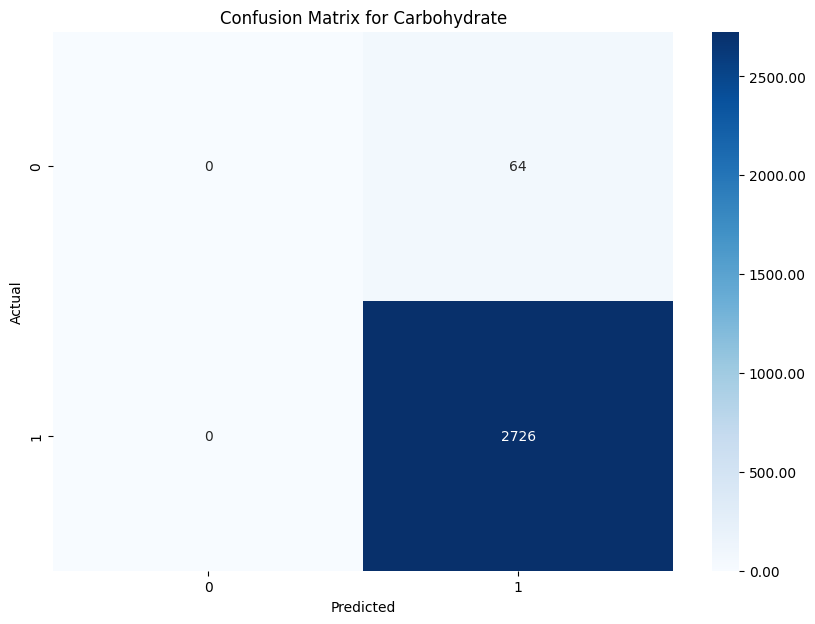

Nutrient: Carbohydrate
  Accuracy: 0.9771
  Precision: 0.4885
  Recall: 0.5000
  F1-score: 0.4942

Fitting 5 folds for each of 81 candidates, totalling 405 fits


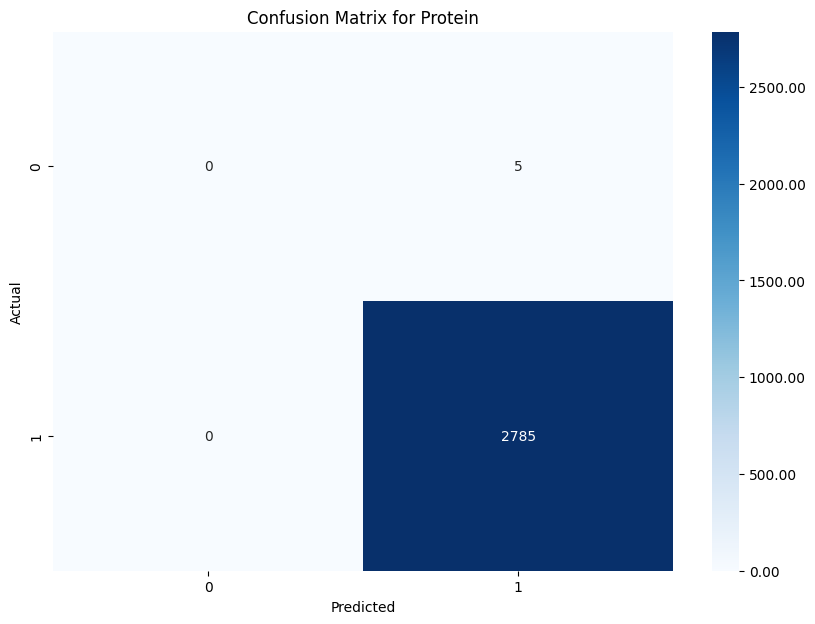

Nutrient: Protein
  Accuracy: 0.9982
  Precision: 0.4991
  Recall: 0.5000
  F1-score: 0.4996

Fitting 5 folds for each of 81 candidates, totalling 405 fits


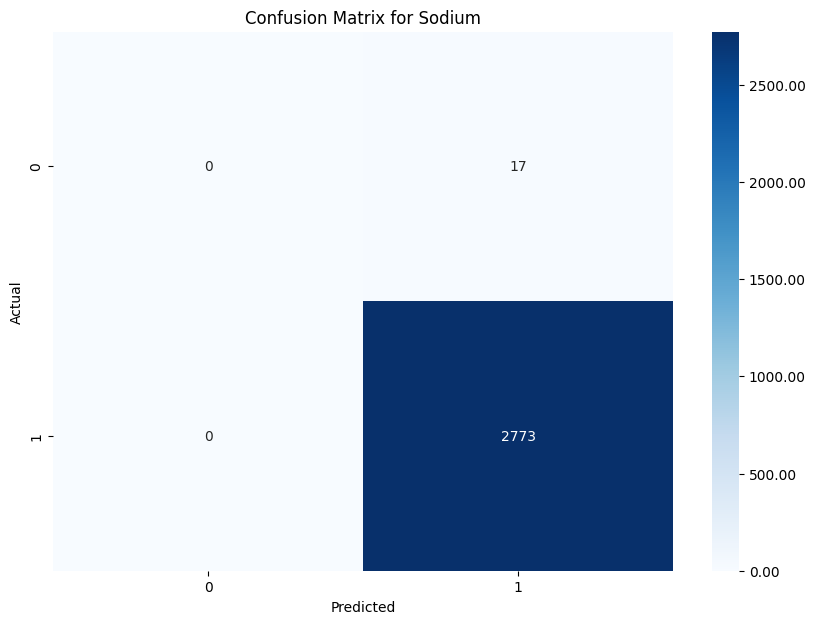

Nutrient: Sodium
  Accuracy: 0.9939
  Precision: 0.4970
  Recall: 0.5000
  F1-score: 0.4985

Fitting 5 folds for each of 81 candidates, totalling 405 fits


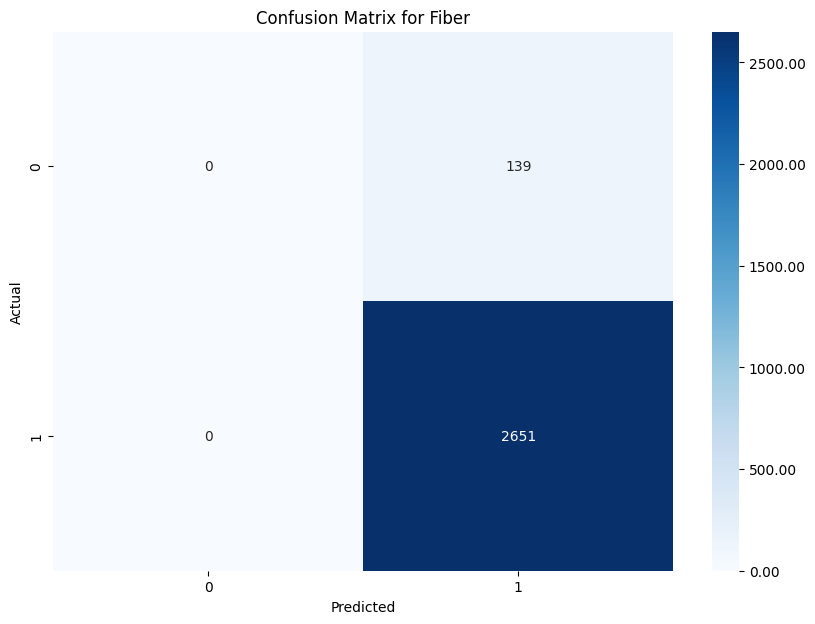

Nutrient: Fiber
  Accuracy: 0.9502
  Precision: 0.4751
  Recall: 0.5000
  F1-score: 0.4872

Fitting 5 folds for each of 81 candidates, totalling 405 fits


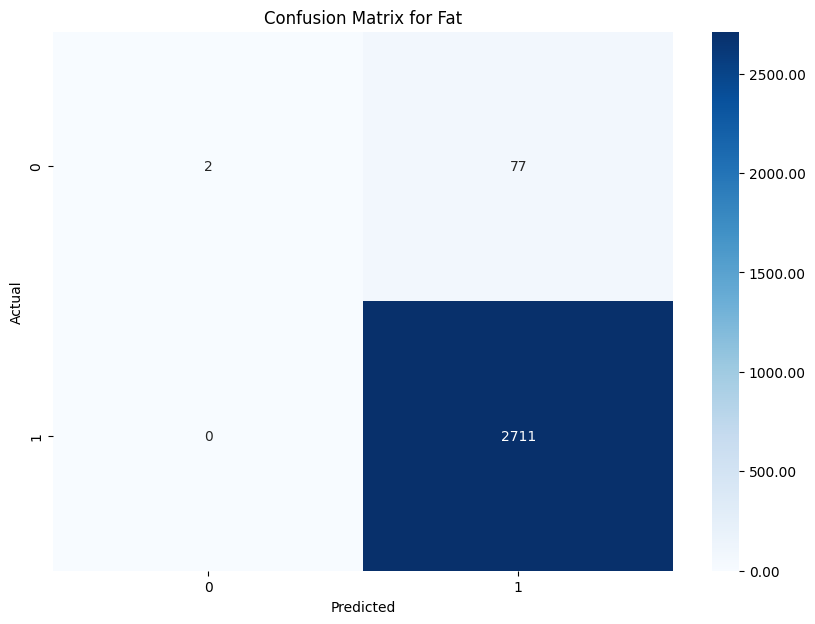

Nutrient: Fat
  Accuracy: 0.9724
  Precision: 0.9862
  Recall: 0.5127
  F1-score: 0.5177

Fitting 5 folds for each of 81 candidates, totalling 405 fits


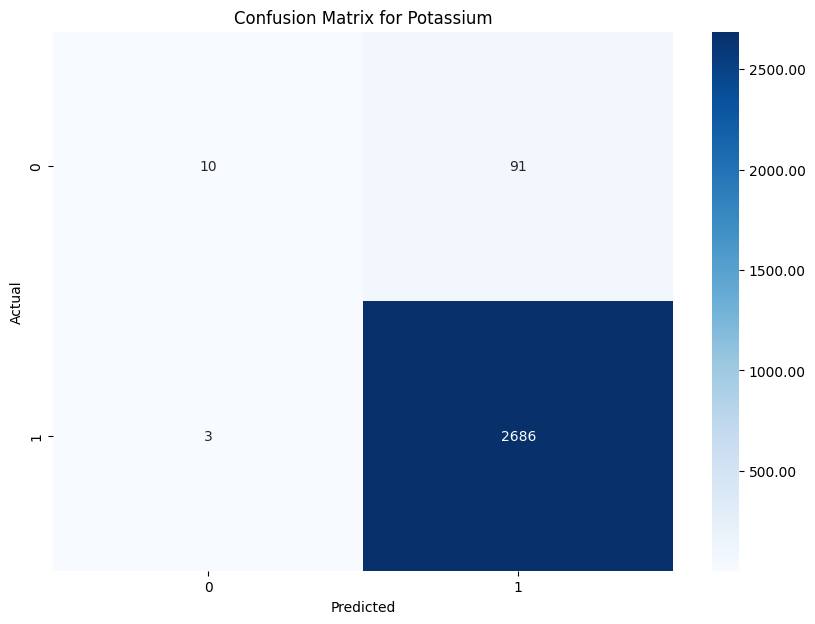

Nutrient: Potassium
  Accuracy: 0.9663
  Precision: 0.8682
  Recall: 0.5489
  F1-score: 0.5791

Fitting 5 folds for each of 81 candidates, totalling 405 fits


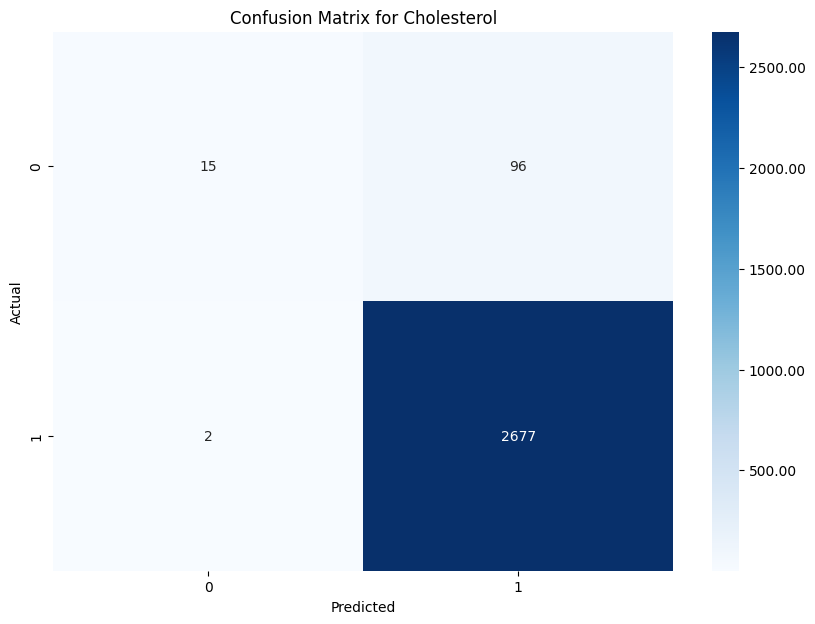

Nutrient: Cholesterol
  Accuracy: 0.9649
  Precision: 0.9239
  Recall: 0.5672
  F1-score: 0.6082

Fitting 5 folds for each of 81 candidates, totalling 405 fits


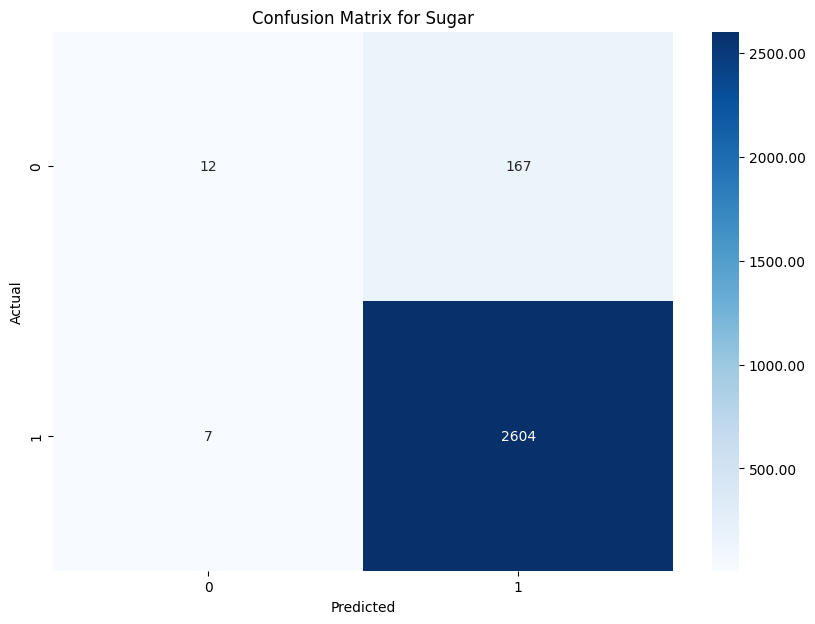

Nutrient: Sugar
  Accuracy: 0.9376
  Precision: 0.7857
  Recall: 0.5322
  F1-score: 0.5444

Average Scores:
Average Accuracy: 0.9701
Average Precision: 0.6905
Average Recall: 0.5201
Average F1-score: 0.5286

Best Parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
import numpy as np

# Scorers for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV setup
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=cv, verbose=1, n_jobs=-1)

# Collect results
results = {}
conf_matrices = {}

for i, column in enumerate(Y_test.columns):  # Assuming Y_test has the same columns as Y_train
    y_true_all = []
    y_pred_all = []

    # Perform GridSearchCV for the current nutrient
    grid_search.fit(X_test, Y_test.iloc[:, i])
    rf_best = grid_search.best_estimator_

    for train_index, test_index in cv.split(X_test, Y_test.iloc[:, i]):
        rf_best.fit(X_test[train_index], Y_test.iloc[train_index, i])
        y_true_fold = Y_test.iloc[test_index, i]
        y_pred_fold = rf_best.predict(X_test[test_index])

        y_true_all.extend(y_true_fold)
        y_pred_all.extend(y_pred_fold)

    # Compute confusion matrix for the current column
    cm = confusion_matrix(y_true_all, y_pred_all)
    conf_matrices[column] = cm

    # Calculate scores
    accuracy = accuracy_score(y_true_all, y_pred_all)
    precision = precision_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    recall = recall_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)

    # Store results
    results[column] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    # Plot the confusion matrix with correct precision
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.4g', cmap='Blues', cbar_kws={'format': '%.2f'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {column}')
    plt.show()

    # Print metrics for each nutrient
    print(f"Nutrient: {column}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print("")

# Print average scores
print("Average Scores:")
avg_accuracy = np.mean([metrics['accuracy'] for metrics in results.values()])
avg_precision = np.mean([metrics['precision'] for metrics in results.values()])
avg_recall = np.mean([metrics['recall'] for metrics in results.values()])
avg_f1 = np.mean([metrics['f1'] for metrics in results.values()])
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")

# Print best parameters from GridSearchCV
print("\nBest Parameters:")
print(grid_search.best_params_)


# **Naive Bayes**

In [ ]:
# Membuat dan melatih model Naive Bayes dengan MultiOutputClassifier
nb = MultinomialNB()
multi_target_nb = MultiOutputClassifier(nb)

In [ ]:
multi_target_nb.fit(X_train_resampled, Y_train_resampled)

# Memprediksi hasil pada testing set
Y_pred_nb = multi_target_nb.predict(X_test)


In [ ]:
# Menghasilkan laporan klasifikasi dan akurasi untuk setiap target (Naive Bayes)
for i, column in enumerate(Y.columns):
    print(f"Classification Report for Naive Bayes - {column}:")
    print(classification_report(Y_test.iloc[:, i], Y_pred_nb[:, i], zero_division=0))
    print(f"Accuracy for Naive Bayes - {column}: {accuracy_score(Y_test.iloc[:, i], Y_pred_nb[:, i])}")
    print("-" * 50)

Classification Report for Naive Bayes - Carbohydrate:
              precision    recall  f1-score   support

           0       0.07      0.59      0.12        64
           1       0.99      0.81      0.89      2726

    accuracy                           0.81      2790
   macro avg       0.53      0.70      0.51      2790
weighted avg       0.97      0.81      0.87      2790

Accuracy for Naive Bayes - Carbohydrate: 0.8050179211469534
--------------------------------------------------
Classification Report for Naive Bayes - Protein:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.82      0.90      2785

    accuracy                           0.81      2790
   macro avg       0.50      0.41      0.45      2790
weighted avg       1.00      0.81      0.90      2790

Accuracy for Naive Bayes - Protein: 0.8139784946236559
--------------------------------------------------
Classification Report for 

In [ ]:
overall_accuracy_nb = calculate_overall_accuracy(Y_test, Y_pred_nb)
print(f"Overall Accuracy for Naive Bayes: {overall_accuracy_nb}")

Overall Accuracy for Naive Bayes: 0.7839157706093189


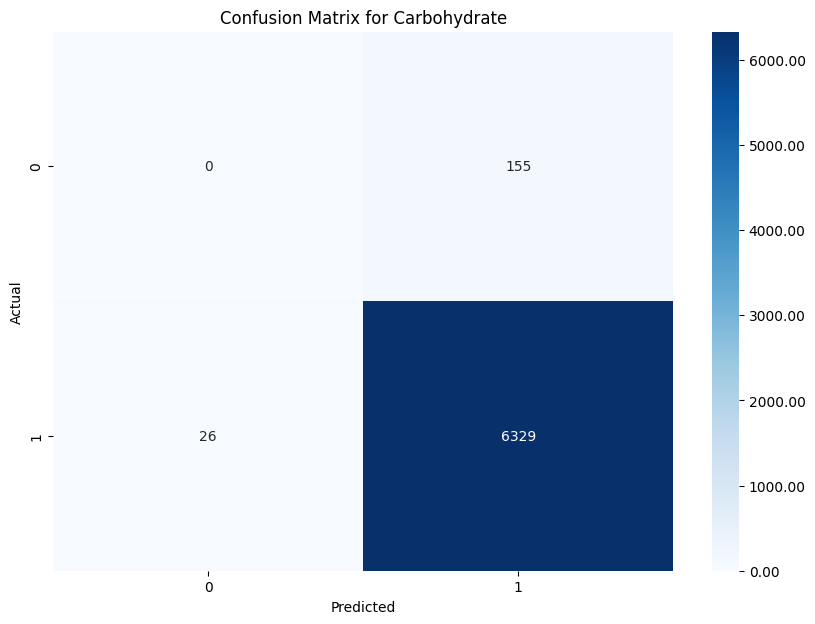

Nutrient: Carbohydrate
  Accuracy: 0.9731
  Precision: 0.4885
  Recall: 0.4980
  F1-score: 0.4932



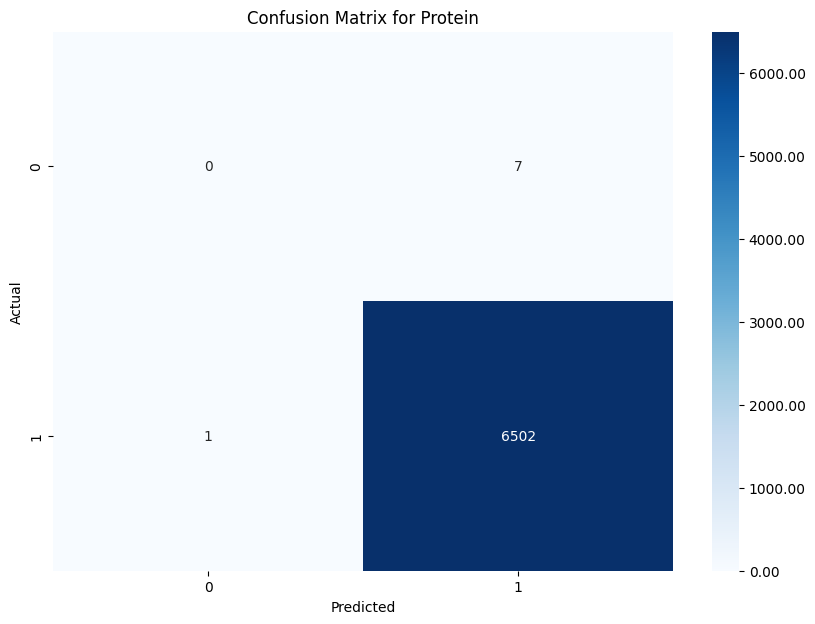

Nutrient: Protein
  Accuracy: 0.9975
  Precision: 0.4991
  Recall: 0.4996
  F1-score: 0.4994



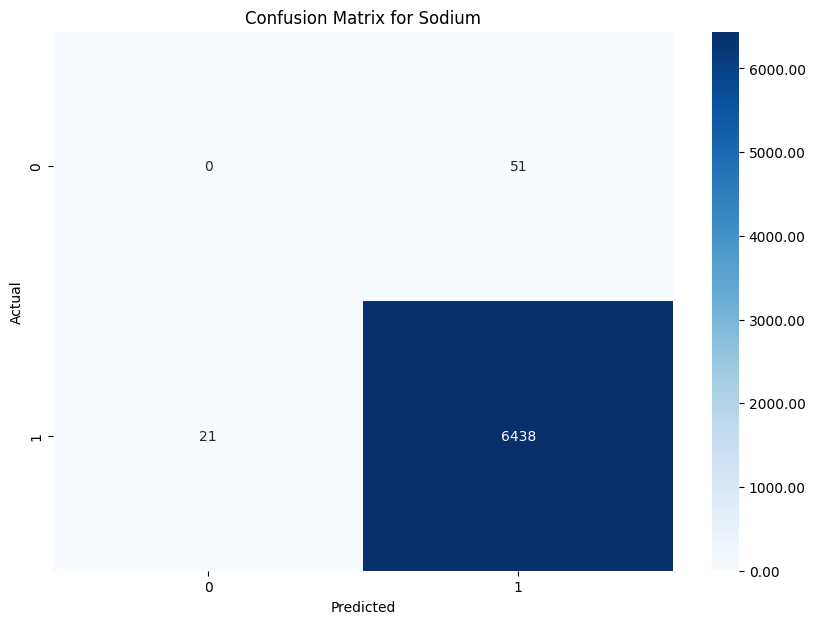

Nutrient: Sodium
  Accuracy: 0.9900
  Precision: 0.4969
  Recall: 0.4980
  F1-score: 0.4975



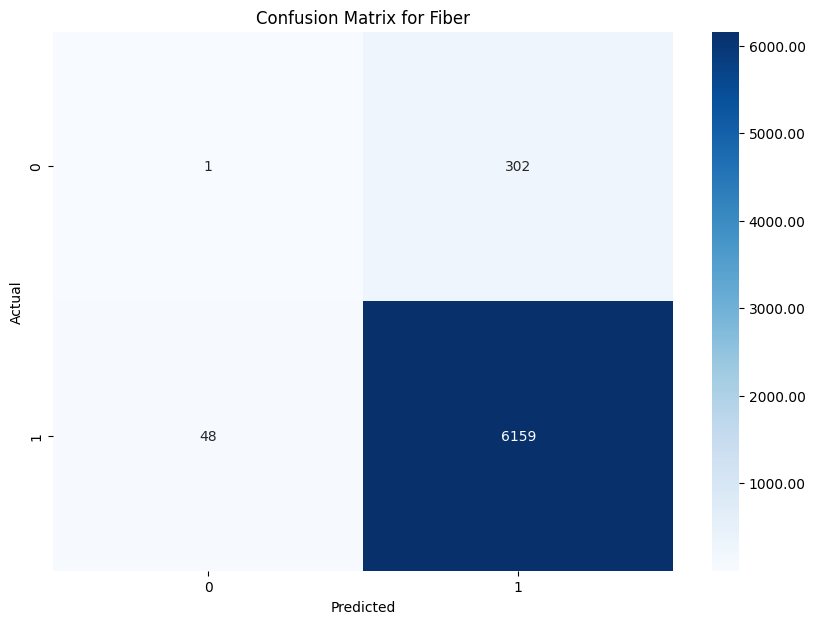

Nutrient: Fiber
  Accuracy: 0.9412
  Precision: 0.4935
  Recall: 0.4987
  F1-score: 0.4909



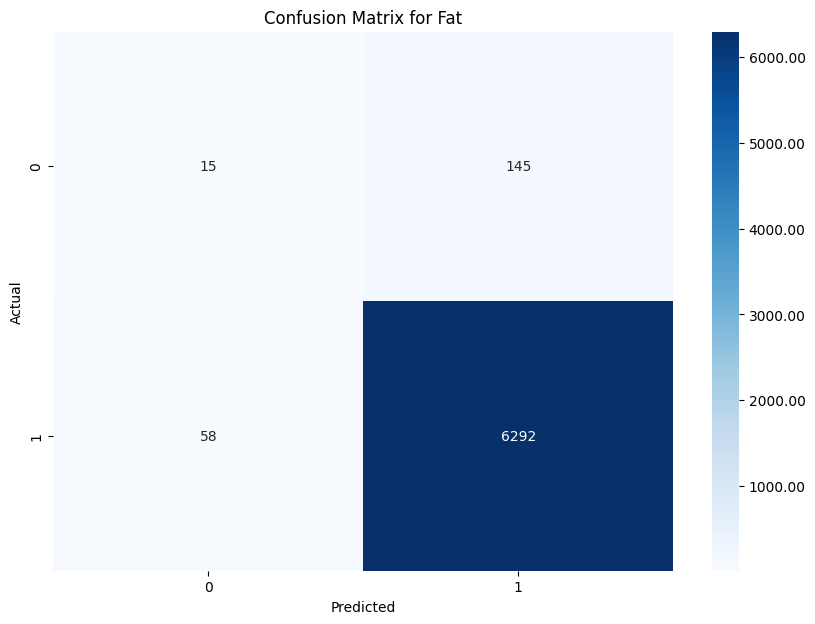

Nutrient: Fat
  Accuracy: 0.9656
  Precision: 0.6437
  Recall: 0.5829
  F1-score: 0.6041



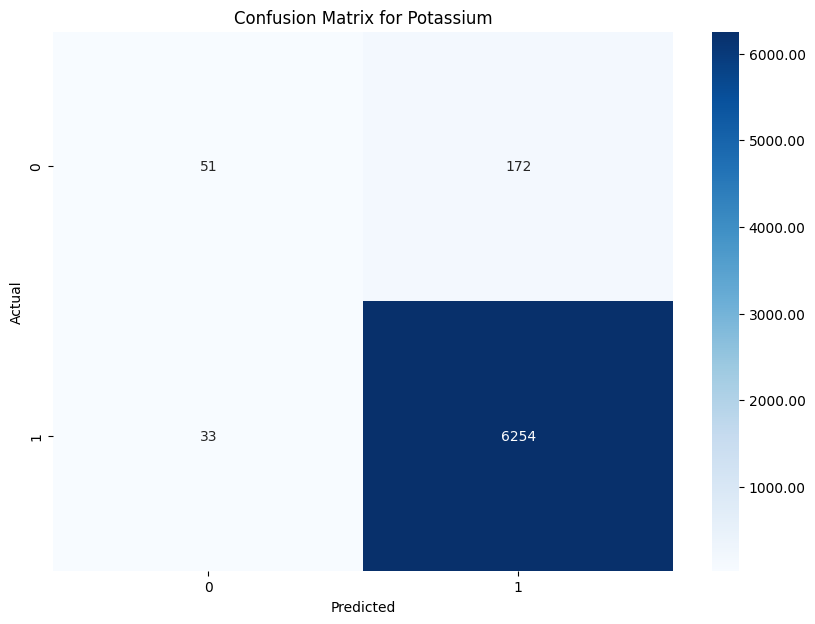

Nutrient: Potassium
  Accuracy: 0.9652
  Precision: 0.7559
  Recall: 0.6342
  F1-score: 0.6741



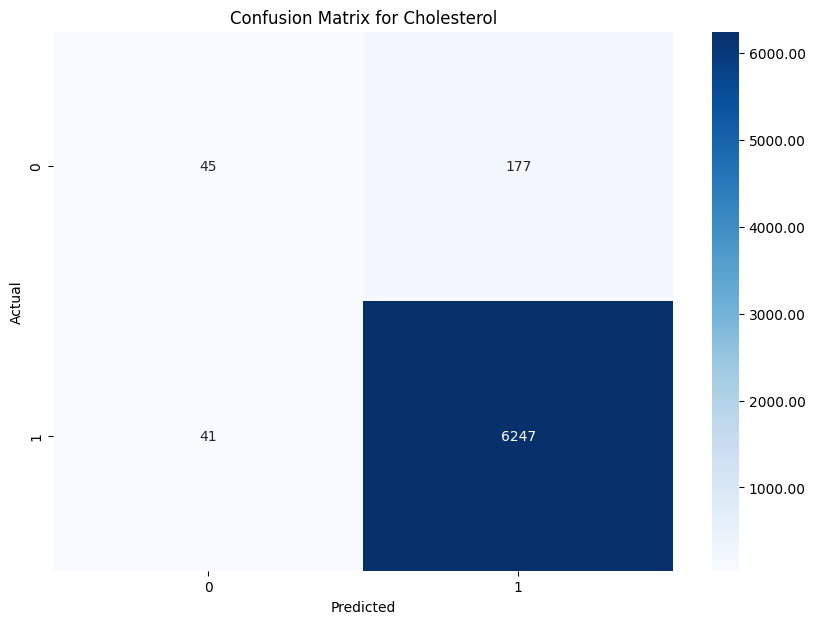

Nutrient: Cholesterol
  Accuracy: 0.9624
  Precision: 0.7639
  Recall: 0.6263
  F1-score: 0.6682



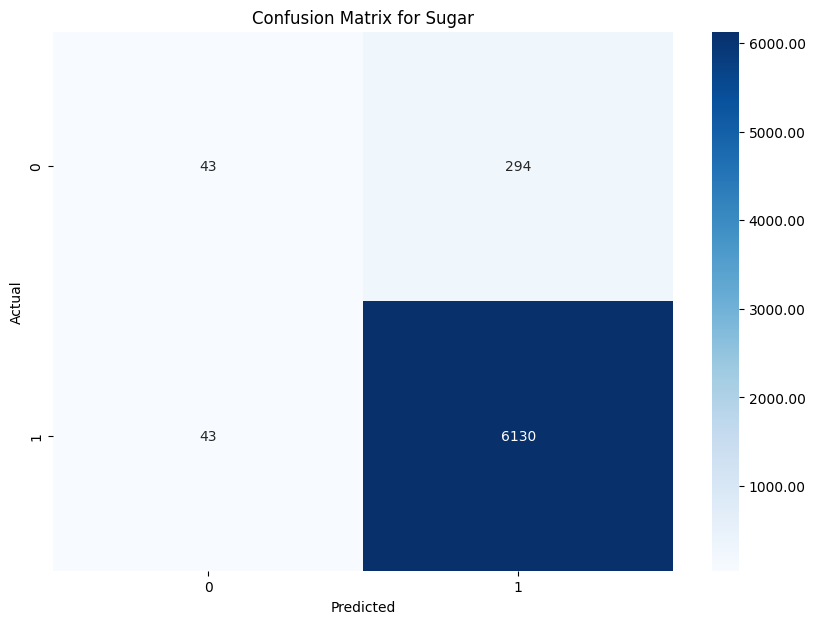

Nutrient: Sugar
  Accuracy: 0.9373
  Precision: 0.7417
  Recall: 0.5736
  F1-score: 0.6049

Average Scores:
Average Accuracy: 0.9665
Average Precision: 0.6104
Average Recall: 0.5514
Average F1-score: 0.5665


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from scipy import sparse

# Skor yang ingin dievaluasi
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Naive Bayes classifier
nb = MultinomialNB()
multi_target_nb = MultiOutputClassifier(nb, n_jobs=-1)

# Collect results
results = {}
conf_matrices = {}

for i, column in enumerate(Y_train.columns):
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in cv.split(X_train, Y_train.iloc[:, i]):
        # Convert X_train to sparse matrix format if not already
        X_train_sparse = sparse.csr_matrix(X_train.values) if not sparse.issparse(X_train) else X_train

        # Reshape y to maintain at least two dimensions
        y_train_column = Y_train.iloc[:, i].values.reshape(-1, 1)

        multi_target_nb.fit(X_train_sparse[train_index], y_train_column[train_index])

        # Predict on the test fold of the training data, not on the actual test data
        y_pred_fold = multi_target_nb.predict(X_train_sparse[test_index])
        y_true_fold = y_train_column[test_index]

        y_true_all.extend(y_true_fold)
        y_pred_all.extend(y_pred_fold)

    # Compute confusion matrix for the current column
    cm = confusion_matrix(y_true_all, y_pred_all)
    conf_matrices[column] = cm

    # Plot the confusion matrix with correct precision
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.4g', cmap='Blues', cbar_kws={'format': '%.2f'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {column}')
    plt.show()

    # Calculate scores using X_test and Y_test
    y_pred_test = multi_target_nb.predict(X_test)
    accuracy = accuracy_score(Y_test.iloc[:, i], y_pred_test)
    precision = precision_score(Y_test.iloc[:, i], y_pred_test, average='macro', zero_division=0)
    recall = recall_score(Y_test.iloc[:, i], y_pred_test, average='macro', zero_division=0)
    f1 = f1_score(Y_test.iloc[:, i], y_pred_test, average='macro', zero_division=0)

    # Store results
    results[column] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    # Print metrics for each nutrient
    print(f"Nutrient: {column}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print("")

# Print average scores
print("Average Scores:")
avg_accuracy = np.mean([metrics['accuracy'] for metrics in results.values()])
avg_precision = np.mean([metrics['precision'] for metrics in results.values()])
avg_recall = np.mean([metrics['recall'] for metrics in results.values()])
avg_f1 = np.mean([metrics['f1'] for metrics in results.values()])
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")


In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
import numpy as np

# Skor yang ingin dievaluasi
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for MultinomialNB
param_grid = {
    'estimator__alpha': [0.01, 0.1, 1, 10]
}

# Initialize Naive Bayes classifier
nb = MultinomialNB()
multi_target_nb = MultiOutputClassifier(nb, n_jobs=-1)

# Setup GridSearchCV
grid_search = GridSearchCV(multi_target_nb, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Collect results
results = {}

for i, column in enumerate(Y_train.columns):
    grid_search.fit(X_train, Y_train.iloc[:, i])
    best_estimator = grid_search.best_estimator_

    scores = cross_validate(best_estimator, X_train, Y_train.iloc[:, i], cv=cv, scoring=scoring, n_jobs=-1)
    results[column] = {
        'accuracy': np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision']),
        'recall': np.mean(scores['test_recall']),
        'f1': np.mean(scores['test_f1'])
    }

# Print results
for column, metrics in results.items():
    print(f"Cross-Validation Results for Naive Bayes - {column}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1']:.4f}")
    print("-" * 50)


# **Decision Tree**

In [ ]:
# Membuat dan melatih model Decision Tree dengan MultiOutputClassifier
dt = DecisionTreeClassifier(random_state=42)
multi_target_dt = MultiOutputClassifier(dt)
multi_target_dt.fit(X_train_resampled, Y_train_resampled)

MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42))

In [ ]:
# Memprediksi hasil pada testing set
Y_pred_dt = multi_target_dt.predict(X_test)

In [ ]:
# Menghasilkan laporan klasifikasi dan akurasi untuk setiap target (Decision Tree)
for i, column in enumerate(Y.columns):
    print(f"Classification Report for Decision Tree - {column}:")
    print(classification_report(Y_test.iloc[:, i], Y_pred_dt[:, i], zero_division=0))
    print(f"Accuracy for Decision Tree - {column}: {accuracy_score(Y_test.iloc[:, i], Y_pred_dt[:, i])}")
    print("-" * 50)

Classification Report for Decision Tree - Carbohydrate:
              precision    recall  f1-score   support

           0       0.05      0.08      0.06        64
           1       0.98      0.96      0.97      2726

    accuracy                           0.94      2790
   macro avg       0.51      0.52      0.52      2790
weighted avg       0.96      0.94      0.95      2790

Accuracy for Decision Tree - Carbohydrate: 0.9437275985663083
--------------------------------------------------
Classification Report for Decision Tree - Protein:
              precision    recall  f1-score   support

           0       0.02      0.40      0.03         5
           1       1.00      0.96      0.98      2785

    accuracy                           0.96      2790
   macro avg       0.51      0.68      0.51      2790
weighted avg       1.00      0.96      0.98      2790

Accuracy for Decision Tree - Protein: 0.9598566308243728
--------------------------------------------------
Classification Rep

In [ ]:
overall_accuracy_dt = calculate_overall_accuracy(Y_test, Y_pred_dt)
print(f"Overall Accuracy for Decision Tree: {overall_accuracy_dt}")

Overall Accuracy for Decision Tree: 0.9211469534050178


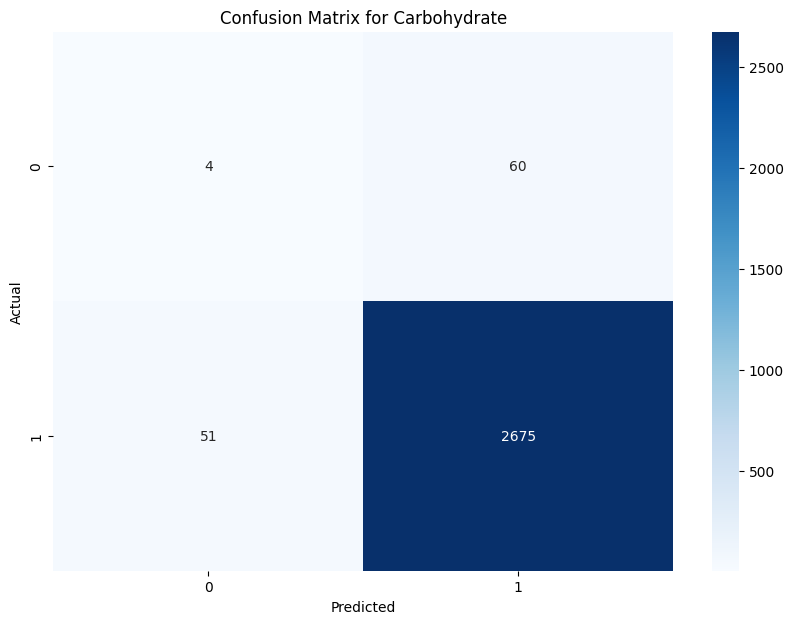

Nutrient: Carbohydrate
  Precision: 0.5254
  Recall: 0.5219
  F1-score: 0.5235



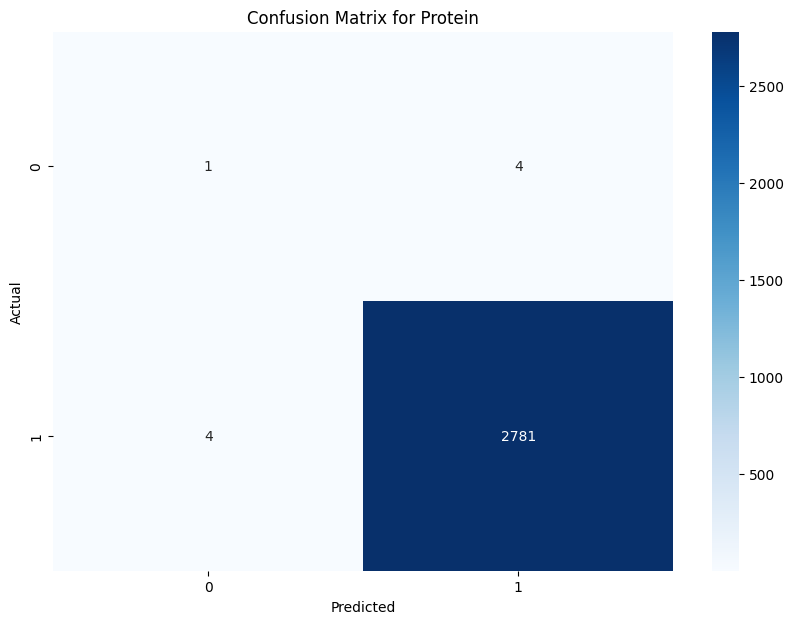

Nutrient: Protein
  Precision: 0.5993
  Recall: 0.5993
  F1-score: 0.5993



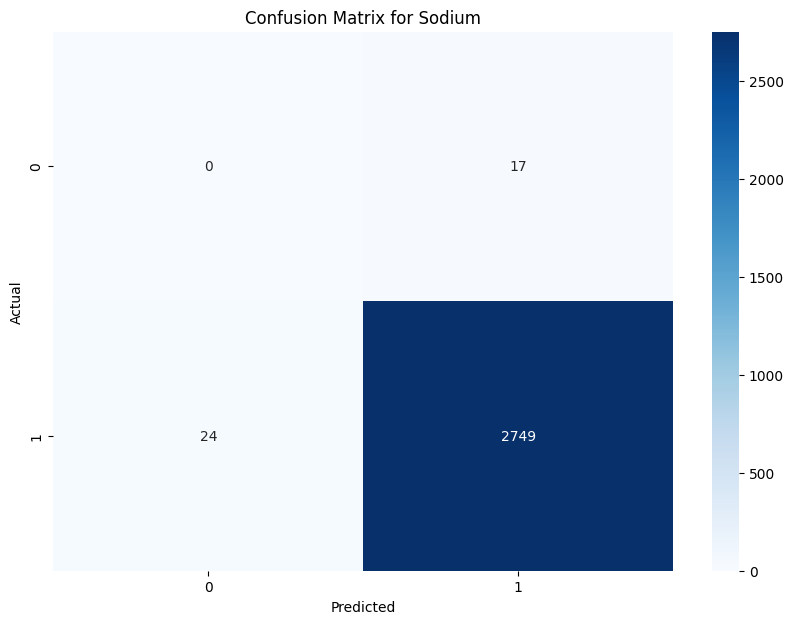

Nutrient: Sodium
  Precision: 0.4969
  Recall: 0.4957
  F1-score: 0.4963



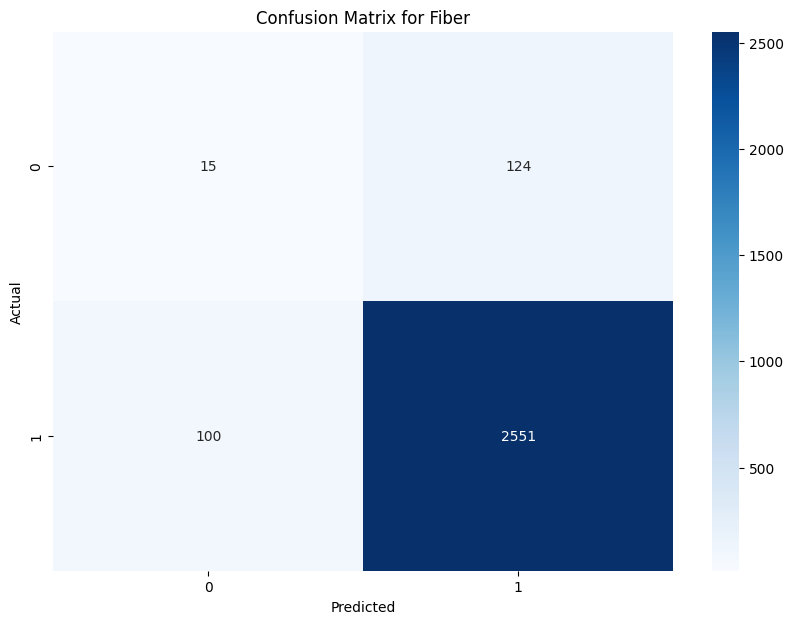

Nutrient: Fiber
  Precision: 0.5420
  Recall: 0.5351
  F1-score: 0.5380



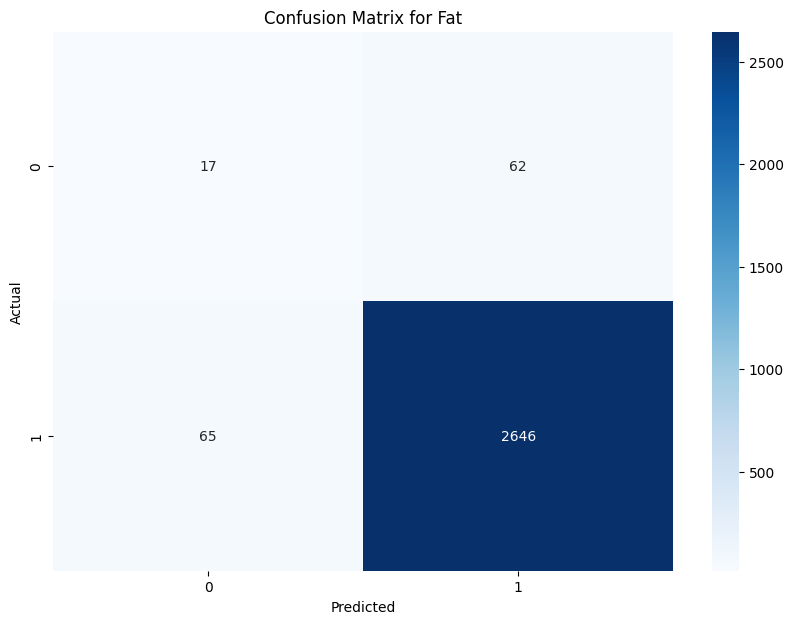

Nutrient: Fat
  Precision: 0.5922
  Recall: 0.5956
  F1-score: 0.5939



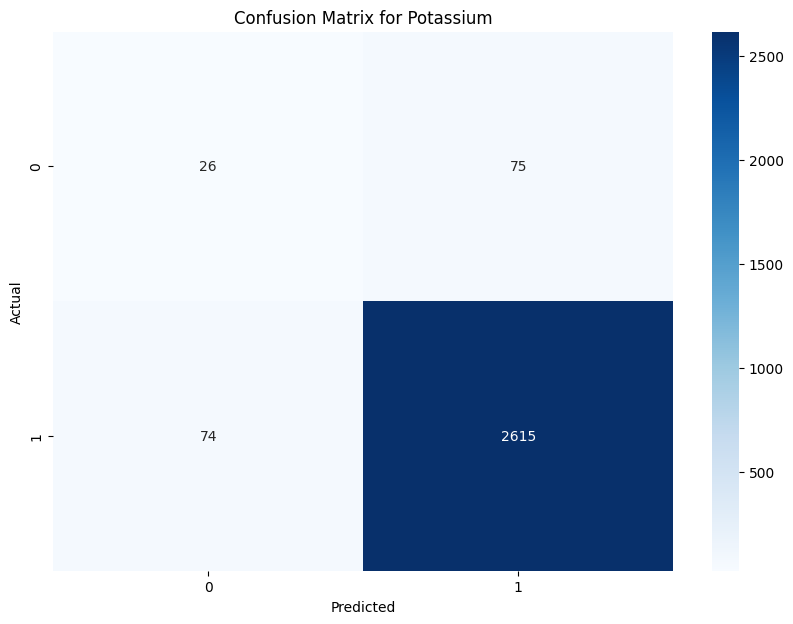

Nutrient: Potassium
  Precision: 0.6161
  Recall: 0.6150
  F1-score: 0.6155



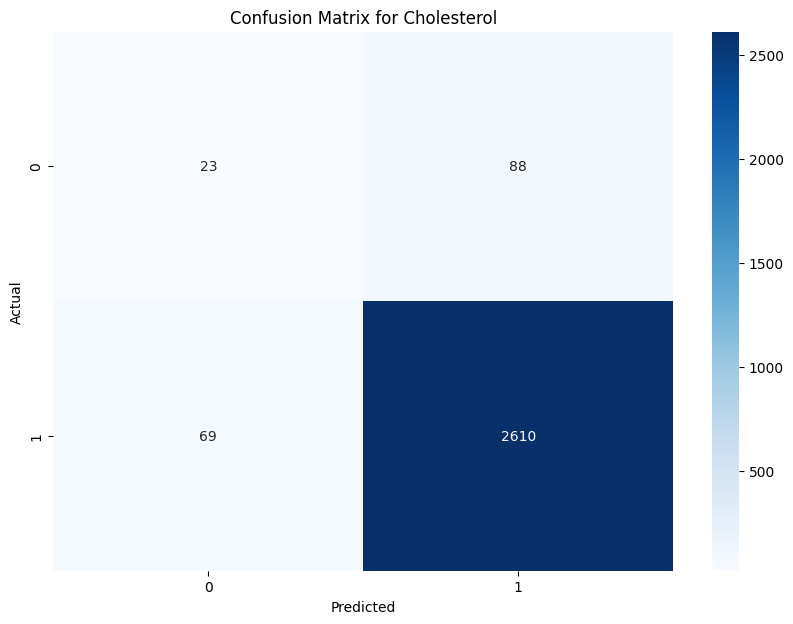

Nutrient: Cholesterol
  Precision: 0.6087
  Recall: 0.5907
  F1-score: 0.5987



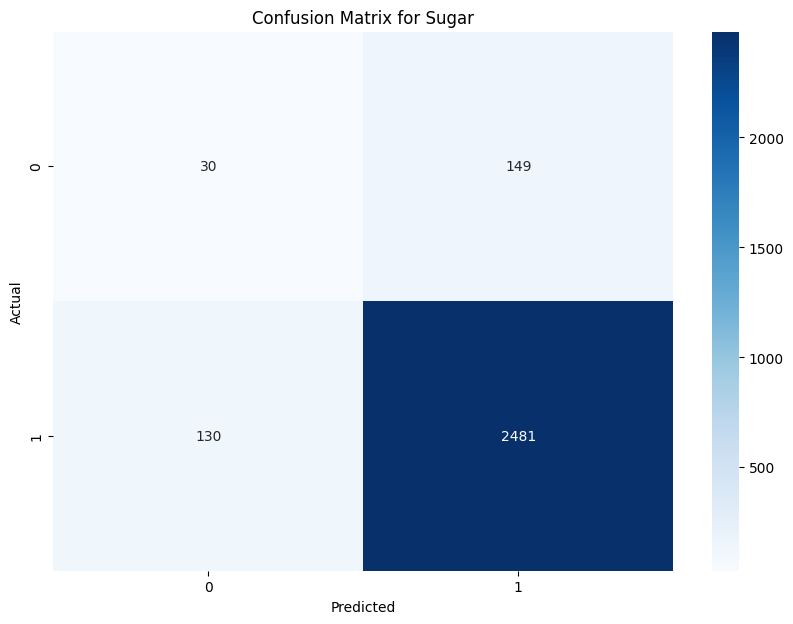

Nutrient: Sugar
  Precision: 0.5654
  Recall: 0.5589
  F1-score: 0.5619

Average Scores:
Accuracy: 0.9509
Precision: 0.5683
Recall: 0.5640
F1-score: 0.5659


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np

# Scorers for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Collect results
results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
conf_matrices = {}

for i, column in enumerate(Y_test.columns):  # Assuming Y_test has the same columns as Y_train
    y_true_all = []
    y_pred_all = []
    accuracies = []  # Store accuracy for each fold

    for train_index, test_index in cv.split(X_test, Y_test.iloc[:, i]):
        dt.fit(X_test[train_index], Y_test.iloc[train_index, i])
        y_true_fold = Y_test.iloc[test_index, i]
        y_pred_fold = dt.predict(X_test[test_index])

        y_true_all.extend(y_true_fold)
        y_pred_all.extend(y_pred_fold)

        # Calculate accuracy for this fold
        accuracy_fold = accuracy_score(y_true_fold, y_pred_fold)
        accuracies.append(accuracy_fold)

    # Compute the confusion matrix for the current column
    cm = confusion_matrix(y_true_all, y_pred_all)
    conf_matrices[column] = cm

    # Calculate average accuracy across all folds for this nutrient
    avg_accuracy = np.mean(accuracies)

    # Store scores
    results['accuracy'].append(avg_accuracy)
    results['precision'].append(precision_score(y_true_all, y_pred_all, average='macro', zero_division=0))
    results['recall'].append(recall_score(y_true_all, y_pred_all, average='macro', zero_division=0))
    results['f1'].append(f1_score(y_true_all, y_pred_all, average='macro', zero_division=0))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {column}')
    plt.show()

    # Print precision, recall, and f1-score for each nutrient
    print(f"Nutrient: {column}")
    print(f"  Precision: {results['precision'][-1]:.4f}")
    print(f"  Recall: {results['recall'][-1]:.4f}")
    print(f"  F1-score: {results['f1'][-1]:.4f}")
    print("")

# Print average scores
print("Average Scores:")
print(f"Accuracy: {np.mean(results['accuracy']):.4f}")
print(f"Precision: {np.mean(results['precision']):.4f}")
print(f"Recall: {np.mean(results['recall']):.4f}")
print(f"F1-score: {np.mean(results['f1']):.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits


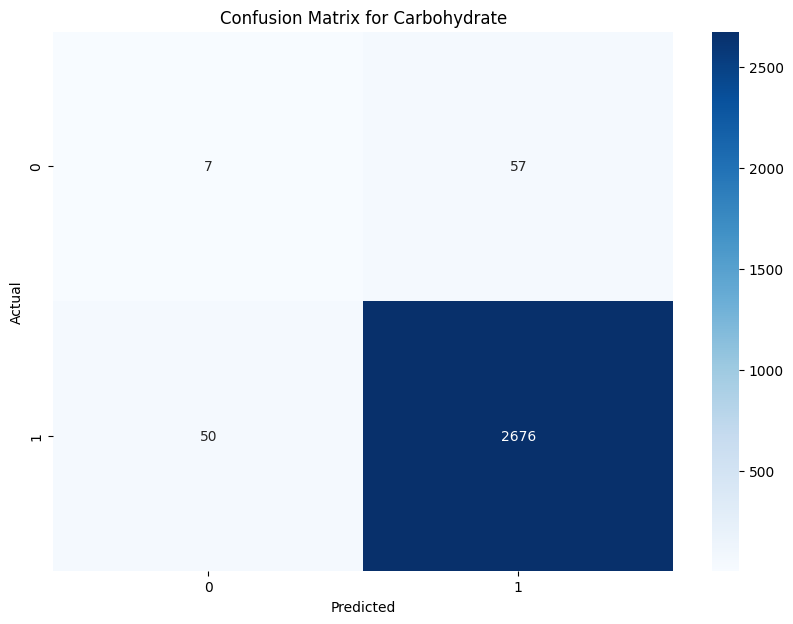

Nutrient: Carbohydrate
  Precision: 0.5510
  Recall: 0.5455
  F1-score: 0.5481

Fitting 5 folds for each of 72 candidates, totalling 360 fits


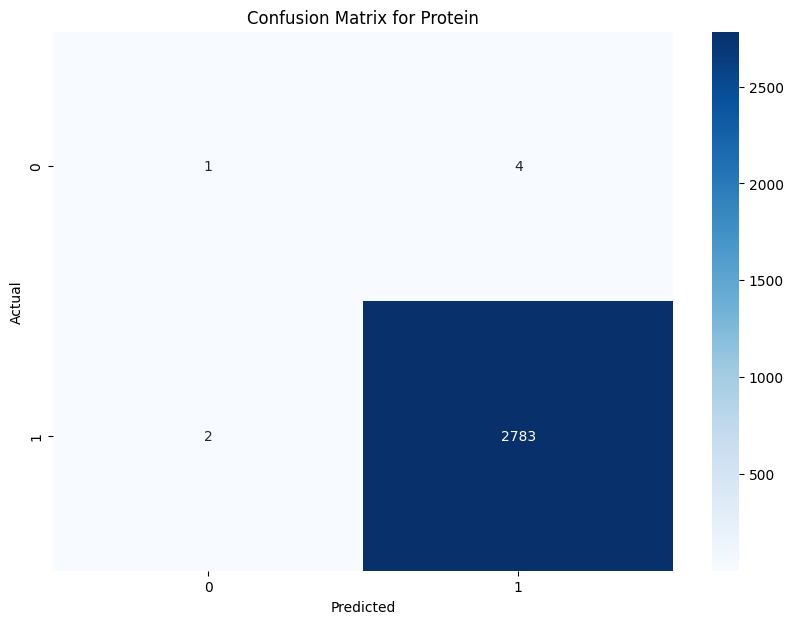

Nutrient: Protein
  Precision: 0.6659
  Recall: 0.5996
  F1-score: 0.6245

Fitting 5 folds for each of 72 candidates, totalling 360 fits


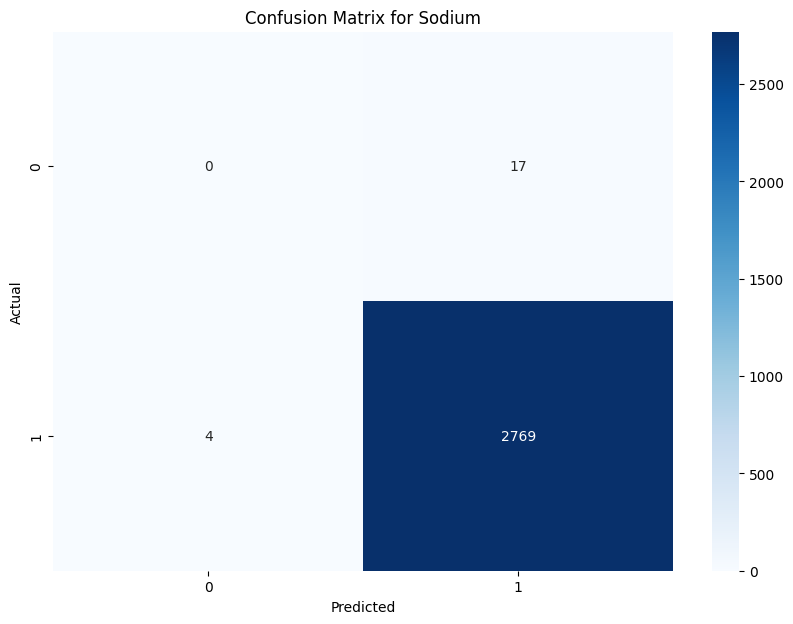

Nutrient: Sodium
  Precision: 0.4969
  Recall: 0.4993
  F1-score: 0.4981

Fitting 5 folds for each of 72 candidates, totalling 360 fits


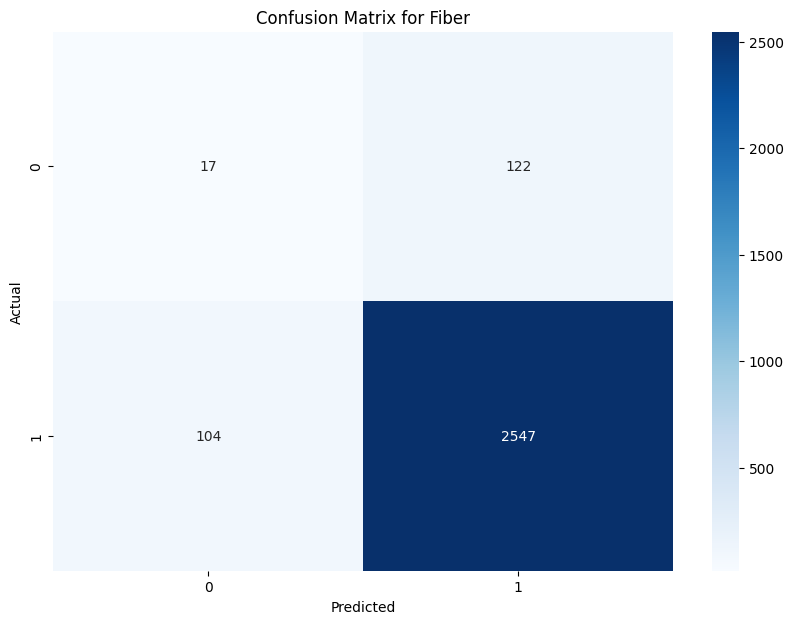

Nutrient: Fiber
  Precision: 0.5474
  Recall: 0.5415
  F1-score: 0.5441

Fitting 5 folds for each of 72 candidates, totalling 360 fits


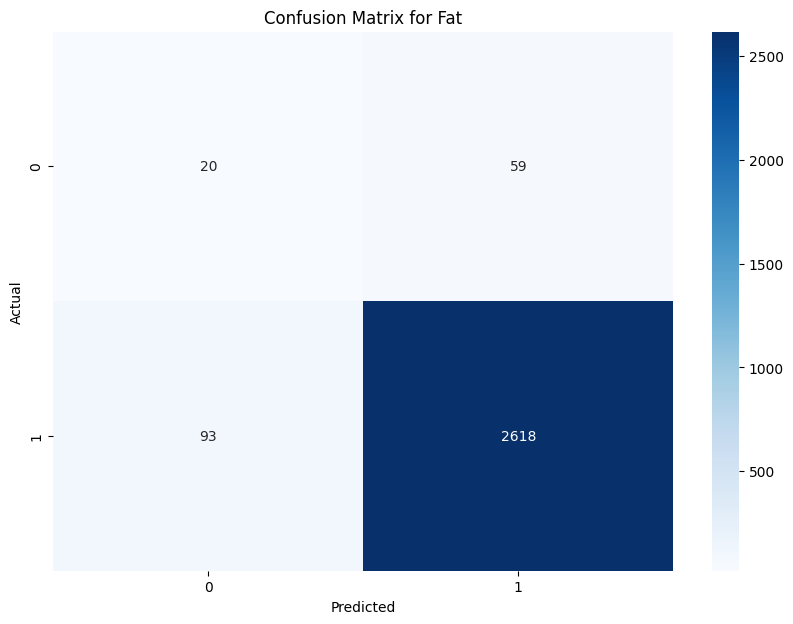

Nutrient: Fat
  Precision: 0.5775
  Recall: 0.6094
  F1-score: 0.5901

Fitting 5 folds for each of 72 candidates, totalling 360 fits


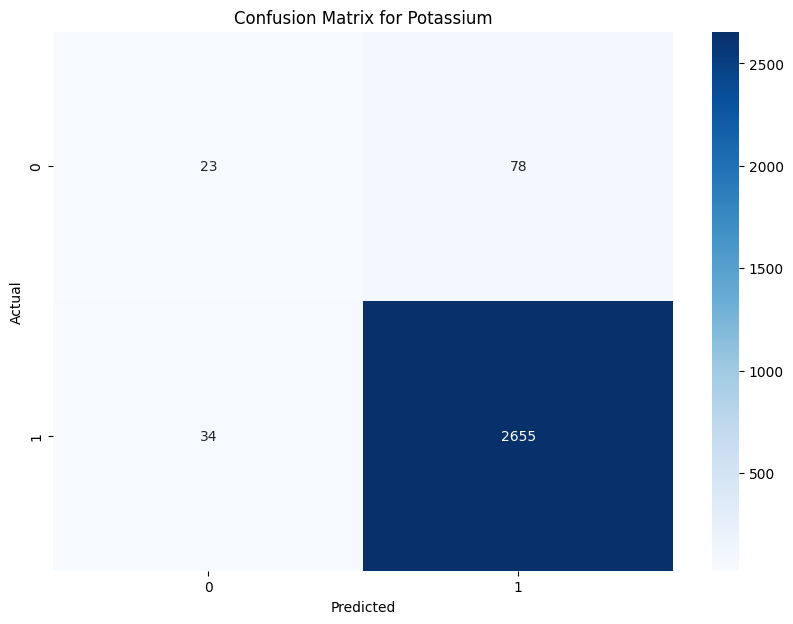

Nutrient: Potassium
  Precision: 0.6875
  Recall: 0.6075
  F1-score: 0.6352

Fitting 5 folds for each of 72 candidates, totalling 360 fits


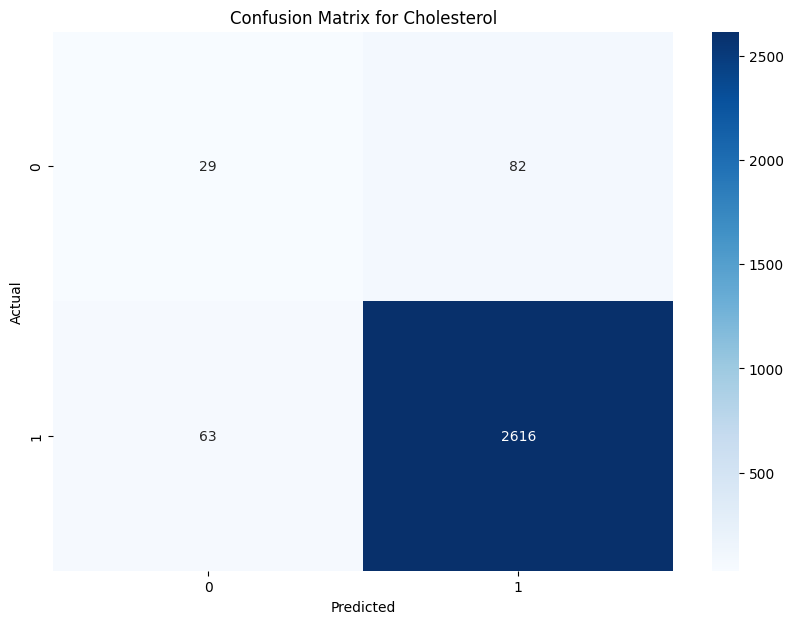

Nutrient: Cholesterol
  Precision: 0.6424
  Recall: 0.6189
  F1-score: 0.6294

Fitting 5 folds for each of 72 candidates, totalling 360 fits


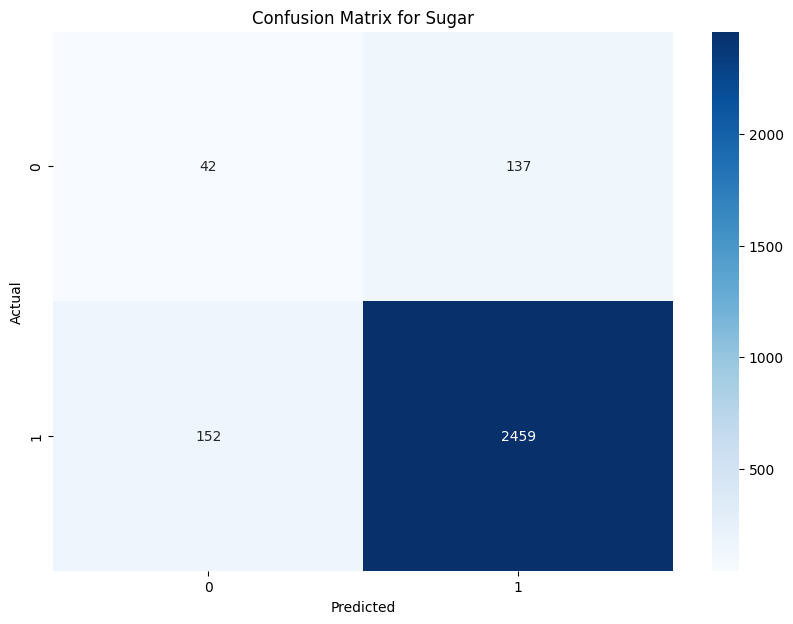

Nutrient: Sugar
  Precision: 0.5819
  Recall: 0.5882
  F1-score: 0.5848

Average Scores:
Accuracy: 0.9526
Precision: 0.5938
Recall: 0.5763
F1-score: 0.5818

Best Parameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
import numpy as np

# Scorers for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV setup
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring=scoring, refit='f1', cv=cv, verbose=1, n_jobs=-1)

# Collect results
results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
conf_matrices = {}

for i, column in enumerate(Y_test.columns):  # Assuming Y_test has the same columns as Y_train
    y_true_all = []
    y_pred_all = []
    accuracies = []  # Store accuracy for each fold

    # Perform GridSearchCV for the current nutrient
    grid_search.fit(X_test, Y_test.iloc[:, i])
    dt_best = grid_search.best_estimator_

    for train_index, test_index in cv.split(X_test, Y_test.iloc[:, i]):
        dt_best.fit(X_test[train_index], Y_test.iloc[train_index, i])
        y_true_fold = Y_test.iloc[test_index, i]
        y_pred_fold = dt_best.predict(X_test[test_index])

        y_true_all.extend(y_true_fold)
        y_pred_all.extend(y_pred_fold)

        # Calculate accuracy for this fold
        accuracy_fold = accuracy_score(y_true_fold, y_pred_fold)
        accuracies.append(accuracy_fold)

    # Compute the confusion matrix for the current column
    cm = confusion_matrix(y_true_all, y_pred_all)
    conf_matrices[column] = cm

    # Calculate average accuracy across all folds for this nutrient
    avg_accuracy = np.mean(accuracies)

    # Store scores
    results['accuracy'].append(avg_accuracy)
    results['precision'].append(precision_score(y_true_all, y_pred_all, average='macro', zero_division=0))
    results['recall'].append(recall_score(y_true_all, y_pred_all, average='macro', zero_division=0))
    results['f1'].append(f1_score(y_true_all, y_pred_all, average='macro', zero_division=0))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {column}')
    plt.show()

    # Print precision, recall, and f1-score for each nutrient
    print(f"Nutrient: {column}")
    print(f"  Precision: {results['precision'][-1]:.4f}")
    print(f"  Recall: {results['recall'][-1]:.4f}")
    print(f"  F1-score: {results['f1'][-1]:.4f}")
    print("")

# Print average scores
print("Average Scores:")
print(f"Accuracy: {np.mean(results['accuracy']):.4f}")
print(f"Precision: {np.mean(results['precision']):.4f}")
print(f"Recall: {np.mean(results['recall']):.4f}")
print(f"F1-score: {np.mean(results['f1']):.4f}")

# Print best parameters from GridSearchCV
print("\nBest Parameters:")
print(grid_search.best_params_)


# **Confusion Matrix**

Classification Report for Naive Bayes - Carbohydrate:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.98      0.99      0.99      2726

    accuracy                           0.97      2790
   macro avg       0.49      0.50      0.49      2790
weighted avg       0.95      0.97      0.96      2790

Accuracy for Naive Bayes - Carbohydrate: 0.9713261648745519
--------------------------------------------------


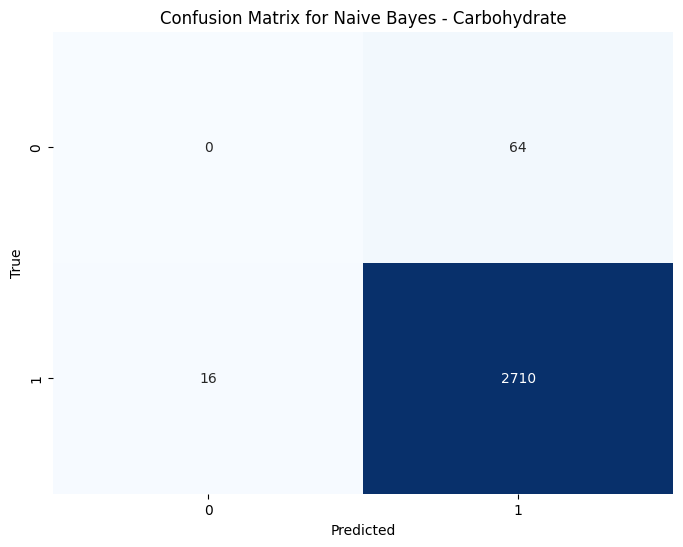

--------------------------------------------------
Classification Report for Naive Bayes - Protein:
              precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       1.00      1.00      1.00      2785

    accuracy                           1.00      2790
   macro avg       0.60      0.60      0.60      2790
weighted avg       1.00      1.00      1.00      2790

Accuracy for Naive Bayes - Protein: 0.9971326164874552
--------------------------------------------------


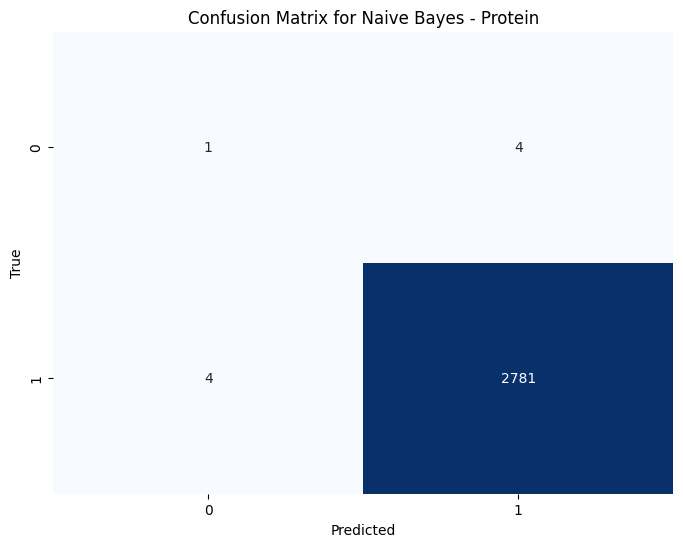

--------------------------------------------------
Classification Report for Naive Bayes - Sodium:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.99      0.99      0.99      2773

    accuracy                           0.99      2790
   macro avg       0.50      0.50      0.50      2790
weighted avg       0.99      0.99      0.99      2790

Accuracy for Naive Bayes - Sodium: 0.9888888888888889
--------------------------------------------------


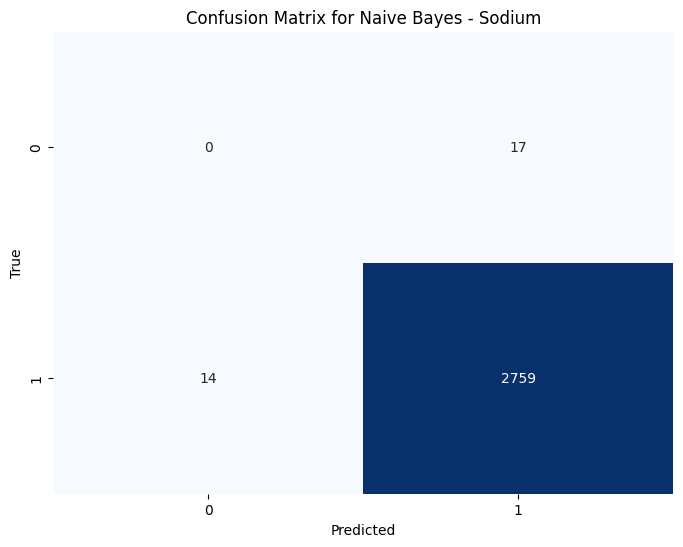

--------------------------------------------------
Classification Report for Naive Bayes - Fiber:
              precision    recall  f1-score   support

           0       0.03      0.01      0.01       139
           1       0.95      0.99      0.97      2651

    accuracy                           0.94      2790
   macro avg       0.49      0.50      0.49      2790
weighted avg       0.90      0.94      0.92      2790

Accuracy for Naive Bayes - Fiber: 0.9401433691756272
--------------------------------------------------


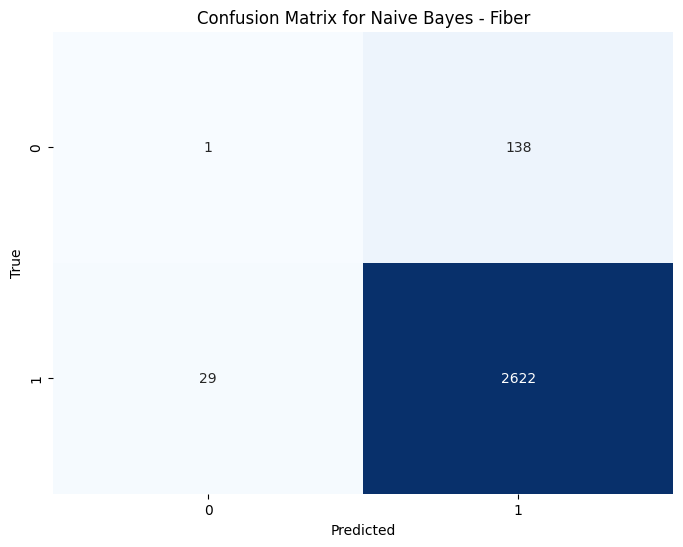

--------------------------------------------------
Classification Report for Naive Bayes - Fat:
              precision    recall  f1-score   support

           0       0.30      0.18      0.22        79
           1       0.98      0.99      0.98      2711

    accuracy                           0.97      2790
   macro avg       0.64      0.58      0.60      2790
weighted avg       0.96      0.97      0.96      2790

Accuracy for Naive Bayes - Fat: 0.9652329749103943
--------------------------------------------------


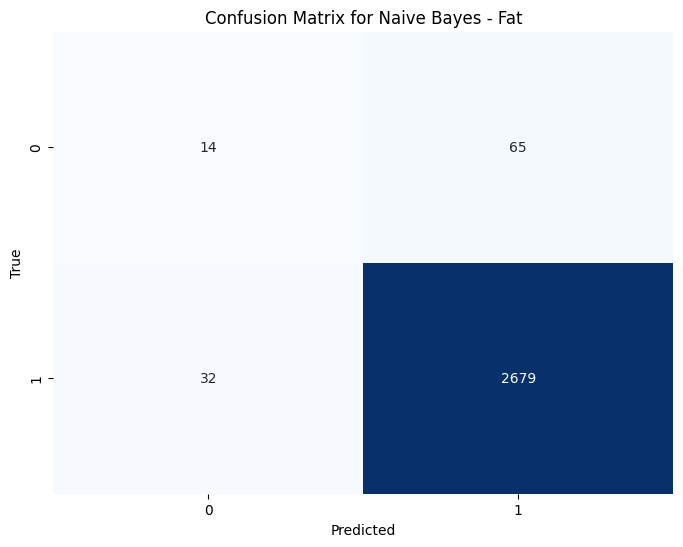

--------------------------------------------------
Classification Report for Naive Bayes - Potassium:
              precision    recall  f1-score   support

           0       0.54      0.28      0.37       101
           1       0.97      0.99      0.98      2689

    accuracy                           0.97      2790
   macro avg       0.76      0.63      0.67      2790
weighted avg       0.96      0.97      0.96      2790

Accuracy for Naive Bayes - Potassium: 0.9652329749103943
--------------------------------------------------


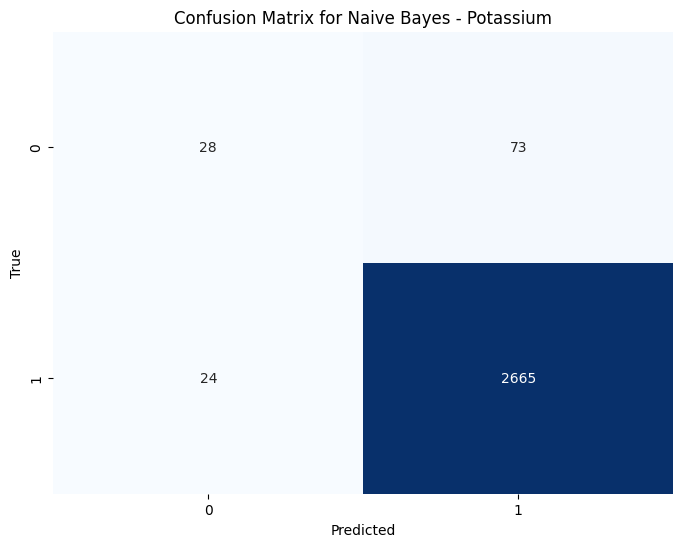

--------------------------------------------------
Classification Report for Naive Bayes - Cholesterol:
              precision    recall  f1-score   support

           0       0.56      0.26      0.36       111
           1       0.97      0.99      0.98      2679

    accuracy                           0.96      2790
   macro avg       0.76      0.63      0.67      2790
weighted avg       0.95      0.96      0.96      2790

Accuracy for Naive Bayes - Cholesterol: 0.9623655913978495
--------------------------------------------------


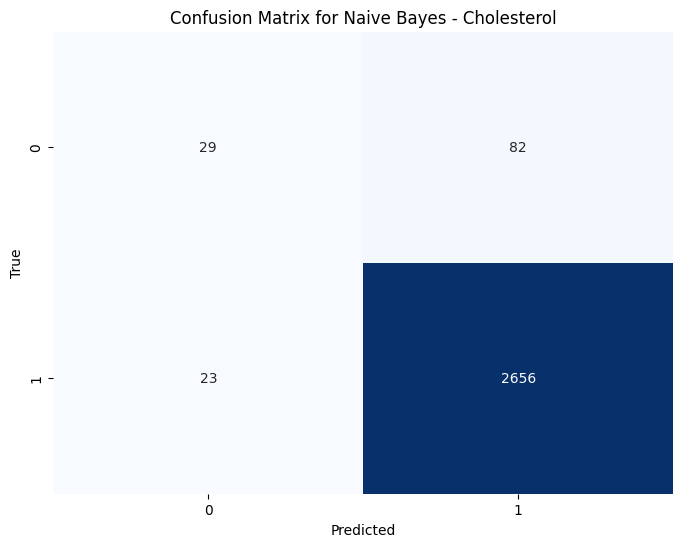

--------------------------------------------------
Classification Report for Naive Bayes - Sugar:
              precision    recall  f1-score   support

           0       0.54      0.16      0.24       179
           1       0.94      0.99      0.97      2611

    accuracy                           0.94      2790
   macro avg       0.74      0.57      0.60      2790
weighted avg       0.92      0.94      0.92      2790

Accuracy for Naive Bayes - Sugar: 0.9372759856630825
--------------------------------------------------


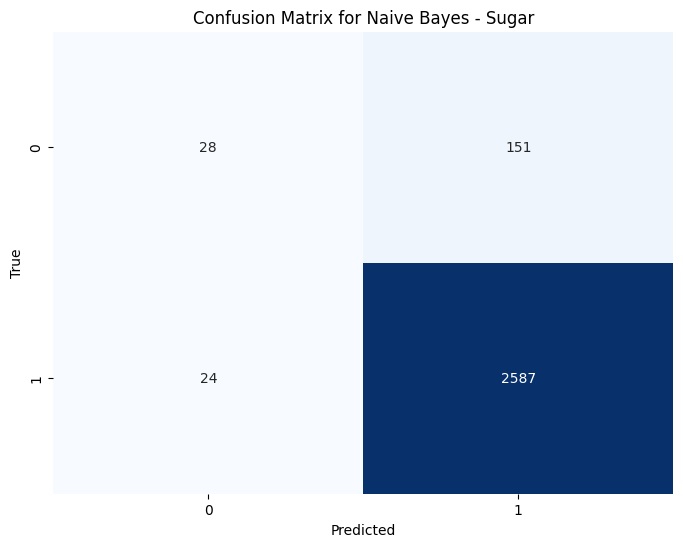

--------------------------------------------------
Classification Report for Random Forest - Carbohydrate:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.98      1.00      0.99      2726

    accuracy                           0.98      2790
   macro avg       0.49      0.50      0.49      2790
weighted avg       0.95      0.98      0.97      2790

Accuracy for Random Forest - Carbohydrate: 0.9759856630824373
--------------------------------------------------


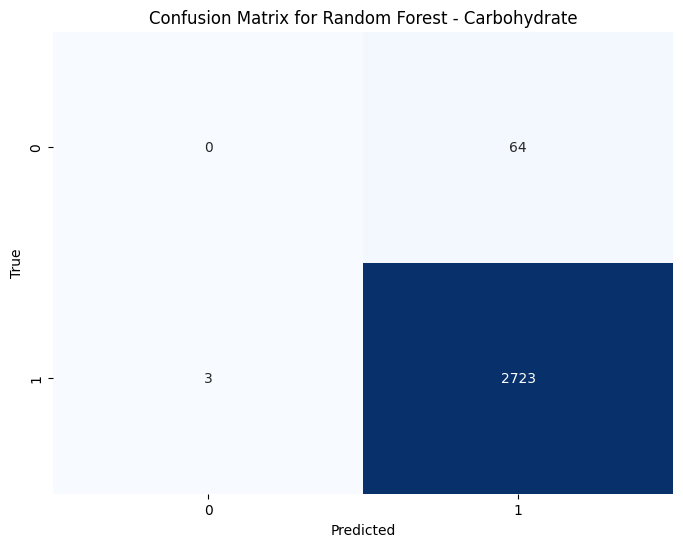

--------------------------------------------------
Classification Report for Random Forest - Protein:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      1.00      1.00      2785

    accuracy                           1.00      2790
   macro avg       0.50      0.50      0.50      2790
weighted avg       1.00      1.00      1.00      2790

Accuracy for Random Forest - Protein: 0.9982078853046595
--------------------------------------------------


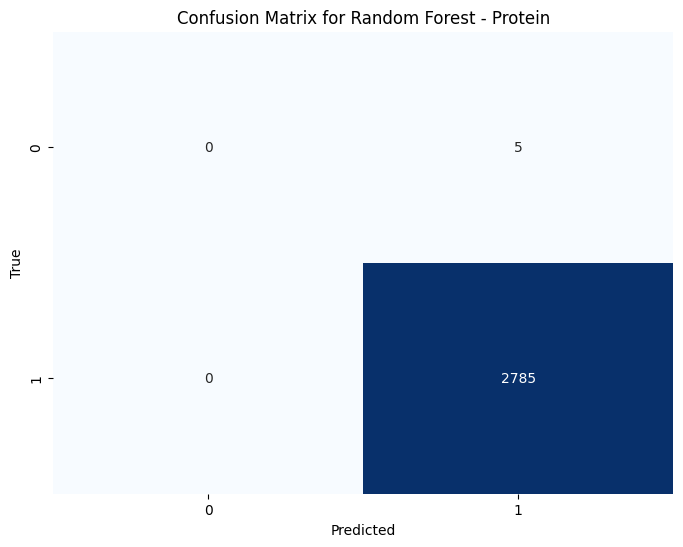

--------------------------------------------------
Classification Report for Random Forest - Sodium:
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        17
           1       0.99      1.00      1.00      2773

    accuracy                           0.99      2790
   macro avg       0.75      0.53      0.55      2790
weighted avg       0.99      0.99      0.99      2790

Accuracy for Random Forest - Sodium: 0.9939068100358422
--------------------------------------------------


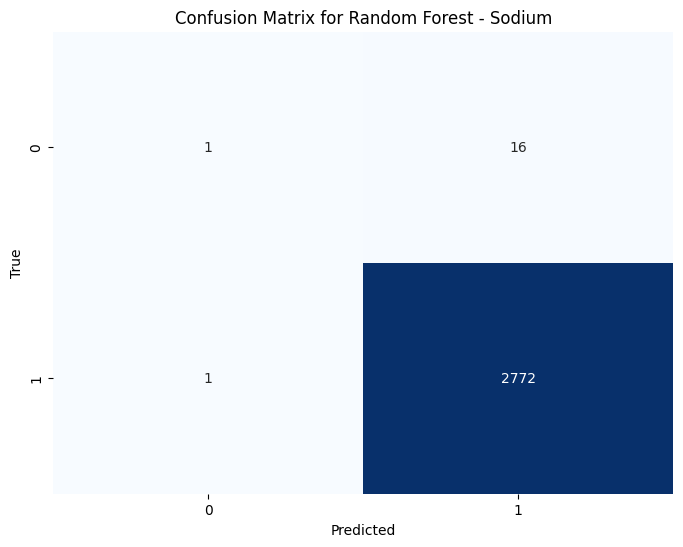

--------------------------------------------------
Classification Report for Random Forest - Fiber:
              precision    recall  f1-score   support

           0       0.50      0.03      0.05       139
           1       0.95      1.00      0.97      2651

    accuracy                           0.95      2790
   macro avg       0.73      0.51      0.51      2790
weighted avg       0.93      0.95      0.93      2790

Accuracy for Random Forest - Fiber: 0.9501792114695341
--------------------------------------------------


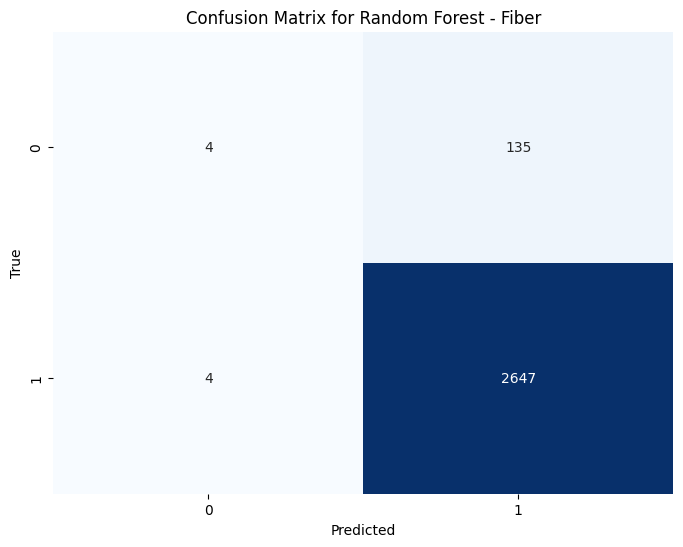

--------------------------------------------------
Classification Report for Random Forest - Fat:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.97      1.00      0.99      2711

    accuracy                           0.97      2790
   macro avg       0.49      0.50      0.49      2790
weighted avg       0.94      0.97      0.96      2790

Accuracy for Random Forest - Fat: 0.9706093189964158
--------------------------------------------------


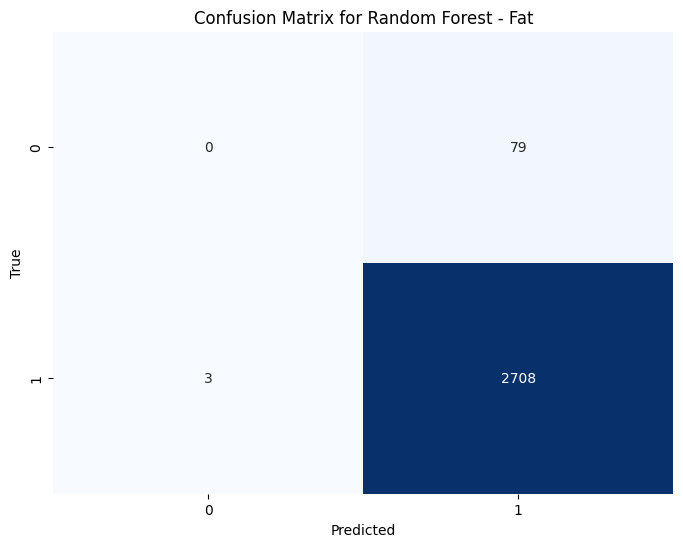

--------------------------------------------------
Classification Report for Random Forest - Potassium:
              precision    recall  f1-score   support

           0       0.73      0.19      0.30       101
           1       0.97      1.00      0.98      2689

    accuracy                           0.97      2790
   macro avg       0.85      0.59      0.64      2790
weighted avg       0.96      0.97      0.96      2790

Accuracy for Random Forest - Potassium: 0.9681003584229391
--------------------------------------------------


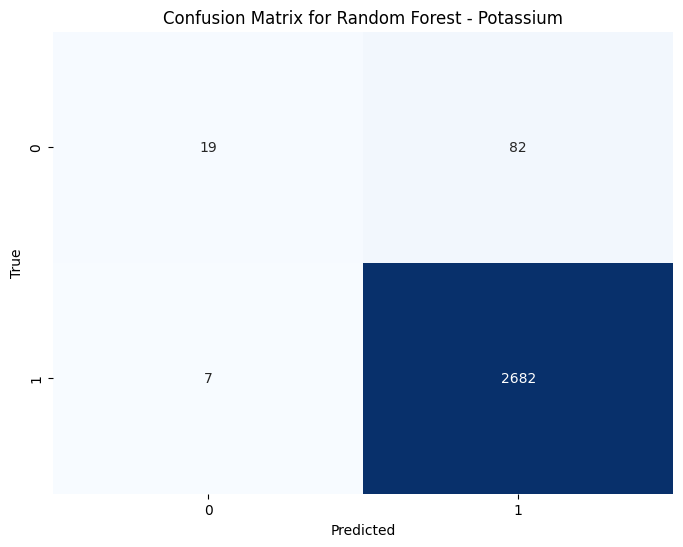

--------------------------------------------------
Classification Report for Random Forest - Cholesterol:
              precision    recall  f1-score   support

           0       0.75      0.14      0.23       111
           1       0.97      1.00      0.98      2679

    accuracy                           0.96      2790
   macro avg       0.86      0.57      0.61      2790
weighted avg       0.96      0.96      0.95      2790

Accuracy for Random Forest - Cholesterol: 0.9637992831541219
--------------------------------------------------


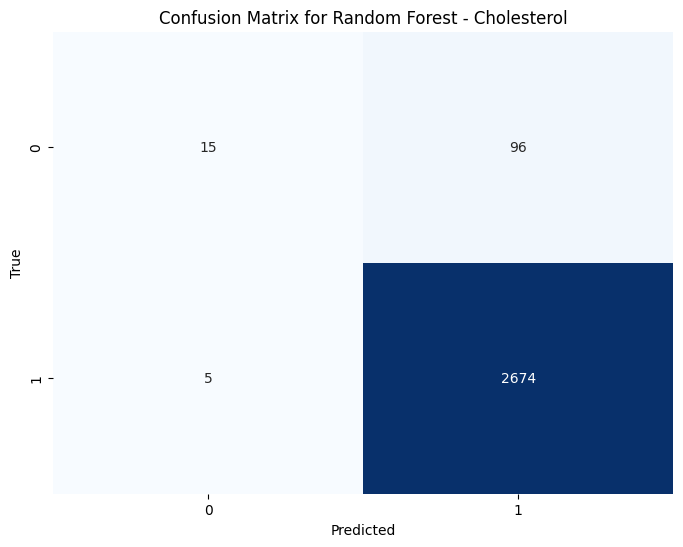

--------------------------------------------------
Classification Report for Random Forest - Sugar:
              precision    recall  f1-score   support

           0       0.75      0.08      0.15       179
           1       0.94      1.00      0.97      2611

    accuracy                           0.94      2790
   macro avg       0.85      0.54      0.56      2790
weighted avg       0.93      0.94      0.92      2790

Accuracy for Random Forest - Sugar: 0.939426523297491
--------------------------------------------------


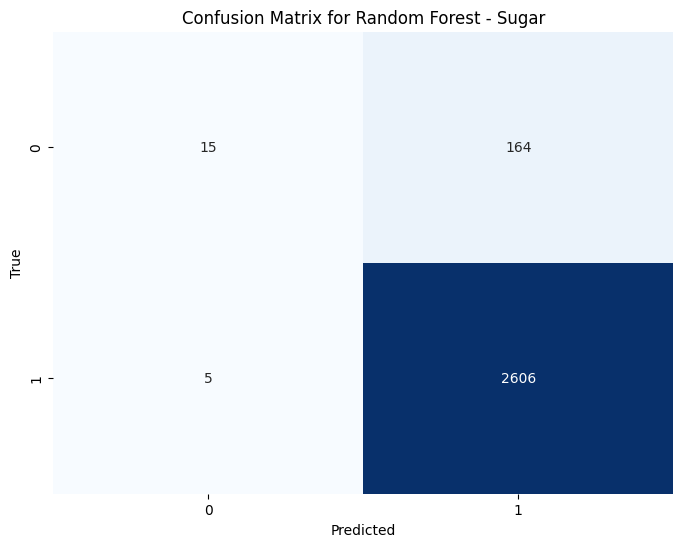

--------------------------------------------------
Classification Report for Decision Tree - Carbohydrate:
              precision    recall  f1-score   support

           0       0.03      0.03      0.03        64
           1       0.98      0.98      0.98      2726

    accuracy                           0.96      2790
   macro avg       0.50      0.50      0.50      2790
weighted avg       0.96      0.96      0.96      2790

Accuracy for Decision Tree - Carbohydrate: 0.9559139784946237
--------------------------------------------------


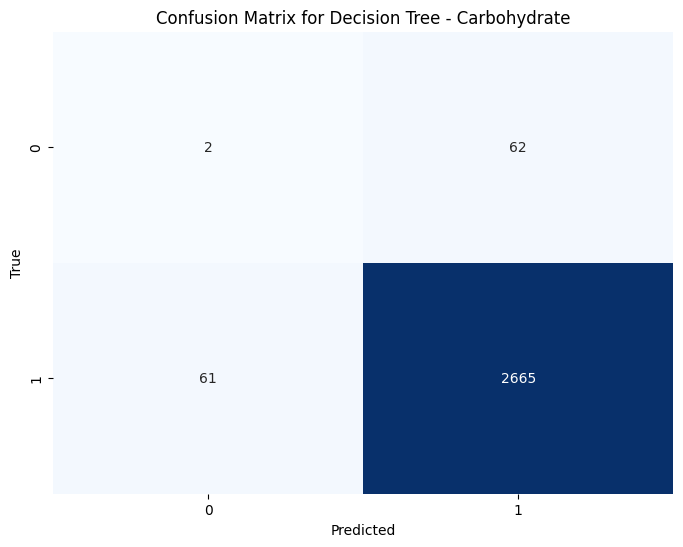

--------------------------------------------------
Classification Report for Decision Tree - Protein:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       1.00      1.00      1.00      2785

    accuracy                           1.00      2790
   macro avg       0.70      0.70      0.70      2790
weighted avg       1.00      1.00      1.00      2790

Accuracy for Decision Tree - Protein: 0.9978494623655914
--------------------------------------------------


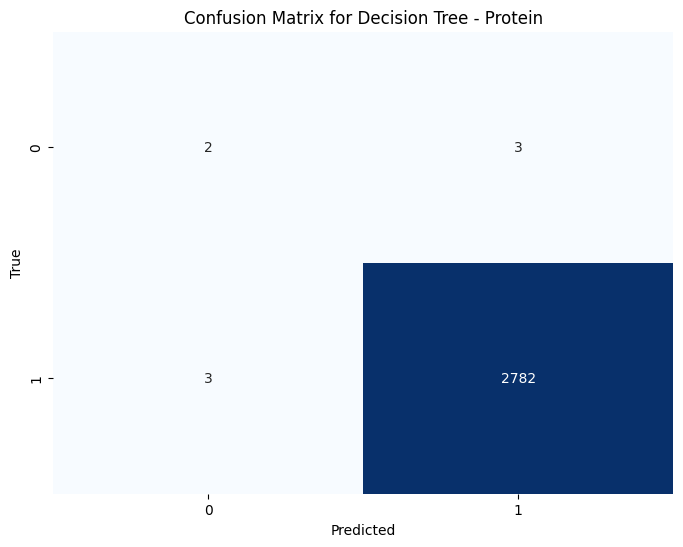

--------------------------------------------------
Classification Report for Decision Tree - Sodium:
              precision    recall  f1-score   support

           0       0.11      0.12      0.11        17
           1       0.99      0.99      0.99      2773

    accuracy                           0.99      2790
   macro avg       0.55      0.56      0.55      2790
weighted avg       0.99      0.99      0.99      2790

Accuracy for Decision Tree - Sodium: 0.9885304659498207
--------------------------------------------------


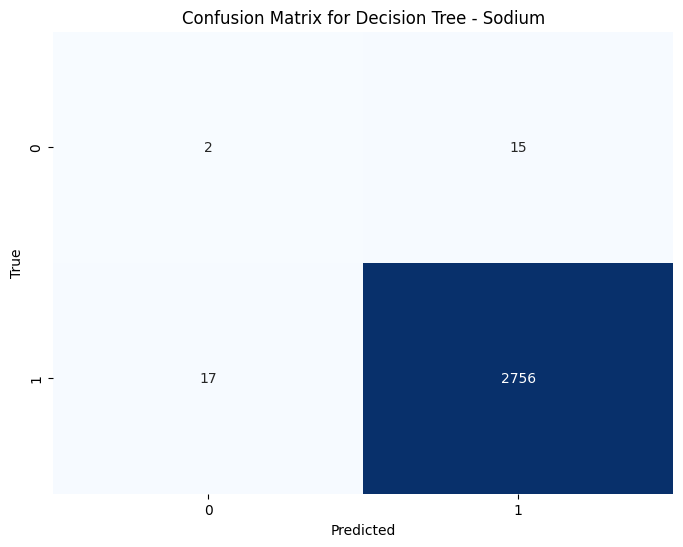

--------------------------------------------------
Classification Report for Decision Tree - Fiber:
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       139
           1       0.95      0.96      0.96      2651

    accuracy                           0.92      2790
   macro avg       0.53      0.53      0.53      2790
weighted avg       0.91      0.92      0.91      2790

Accuracy for Decision Tree - Fiber: 0.9168458781362007
--------------------------------------------------


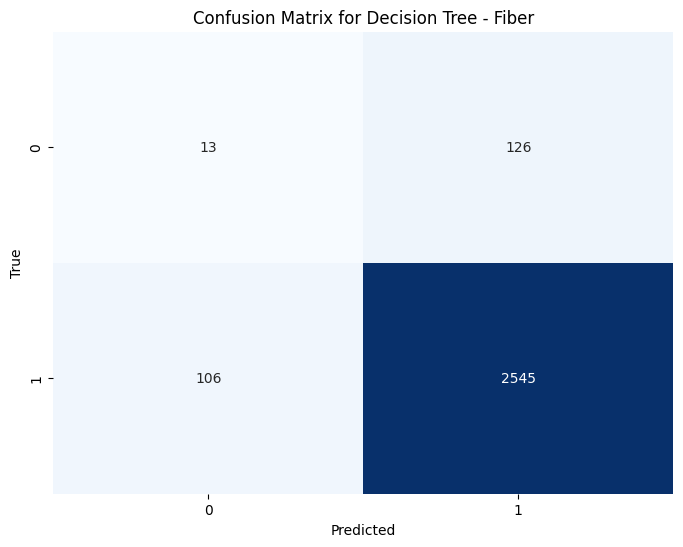

--------------------------------------------------
Classification Report for Decision Tree - Fat:
              precision    recall  f1-score   support

           0       0.12      0.10      0.11        79
           1       0.97      0.98      0.98      2711

    accuracy                           0.95      2790
   macro avg       0.55      0.54      0.54      2790
weighted avg       0.95      0.95      0.95      2790

Accuracy for Decision Tree - Fat: 0.9541218637992831
--------------------------------------------------


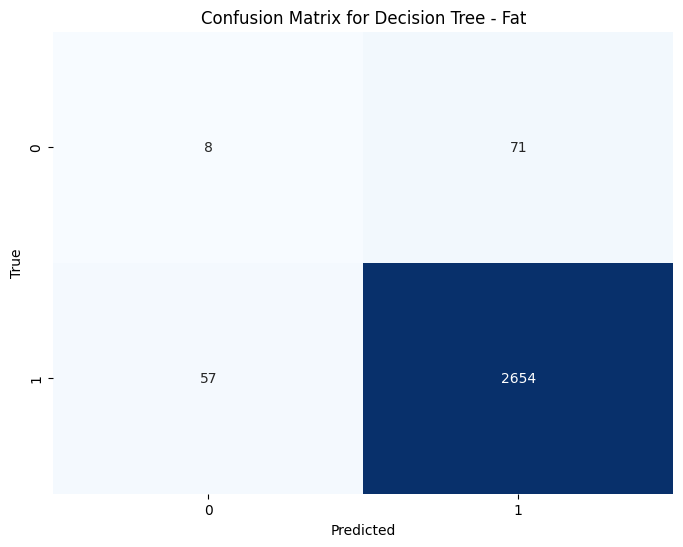

--------------------------------------------------
Classification Report for Decision Tree - Potassium:
              precision    recall  f1-score   support

           0       0.23      0.23      0.23       101
           1       0.97      0.97      0.97      2689

    accuracy                           0.94      2790
   macro avg       0.60      0.60      0.60      2790
weighted avg       0.94      0.94      0.94      2790

Accuracy for Decision Tree - Potassium: 0.9444444444444444
--------------------------------------------------


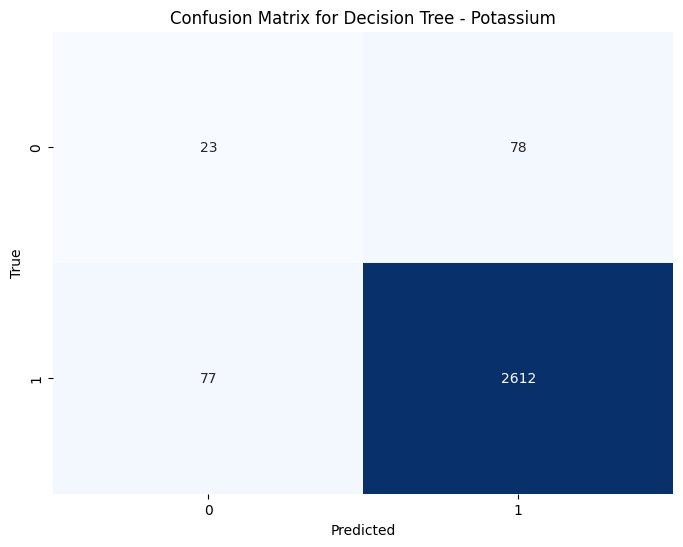

--------------------------------------------------
Classification Report for Decision Tree - Cholesterol:
              precision    recall  f1-score   support

           0       0.20      0.15      0.17       111
           1       0.97      0.97      0.97      2679

    accuracy                           0.94      2790
   macro avg       0.58      0.56      0.57      2790
weighted avg       0.93      0.94      0.94      2790

Accuracy for Decision Tree - Cholesterol: 0.9415770609318996
--------------------------------------------------


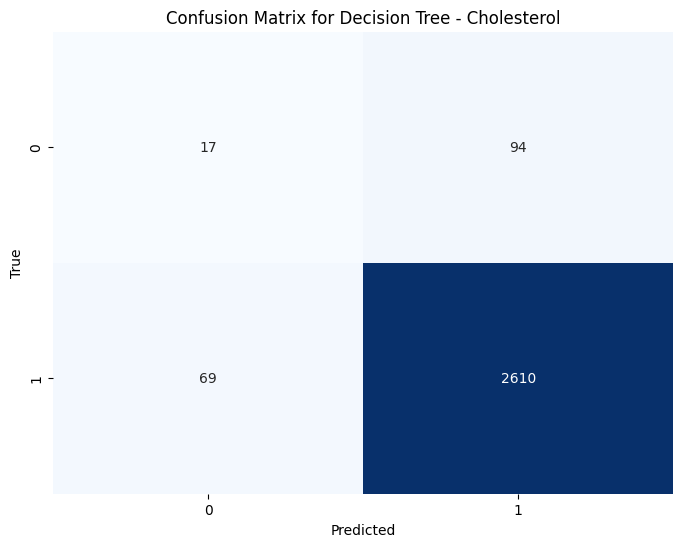

--------------------------------------------------
Classification Report for Decision Tree - Sugar:
              precision    recall  f1-score   support

           0       0.23      0.18      0.20       179
           1       0.94      0.96      0.95      2611

    accuracy                           0.91      2790
   macro avg       0.58      0.57      0.58      2790
weighted avg       0.90      0.91      0.90      2790

Accuracy for Decision Tree - Sugar: 0.9078853046594982
--------------------------------------------------


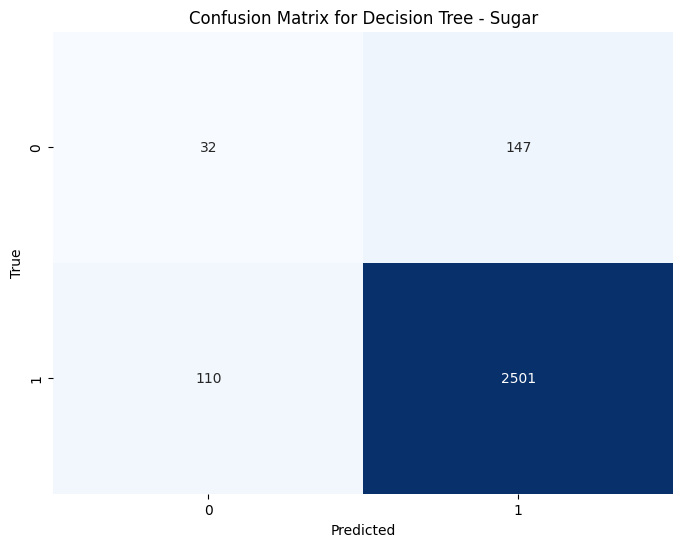

--------------------------------------------------
Overall Accuracy for Naive Bayes: 0.9659498207885304
Overall Accuracy for Random Forest: 0.9700268817204301
Overall Accuracy for Decision Tree: 0.9508960573476702


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Assuming X_tfidf and Y are already defined
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.3, random_state=42)

# Naive Bayes Classifier
nb = MultinomialNB()
multi_target_nb = MultiOutputClassifier(nb, n_jobs=-1)
multi_target_nb.fit(X_train, Y_train)
Y_pred_nb = multi_target_nb.predict(X_test)

# Evaluasi model Naive Bayes
for i, column in enumerate(Y.columns):
    print(f"Classification Report for Naive Bayes - {column}:")
    print(classification_report(Y_test.iloc[:, i], Y_pred_nb[:, i], zero_division=1))
    print(f"Accuracy for Naive Bayes - {column}: {accuracy_score(Y_test.iloc[:, i], Y_pred_nb[:, i])}")
    print("-" * 50)

    # Membuat confusion matrix untuk Naive Bayes
    cm_nb = confusion_matrix(Y_test.iloc[:, i], Y_pred_nb[:, i])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Naive Bayes - {column}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("-" * 50)

# RandomForest Classifier
rf = RandomForestClassifier(random_state=42)
multi_target_forest = MultiOutputClassifier(rf, n_jobs=-1)
multi_target_forest.fit(X_train, Y_train)
Y_pred_rf = multi_target_forest.predict(X_test)

# Evaluasi model Random Forest
for i, column in enumerate(Y.columns):
    print(f"Classification Report for Random Forest - {column}:")
    print(classification_report(Y_test.iloc[:, i], Y_pred_rf[:, i], zero_division=0))
    print(f"Accuracy for Random Forest - {column}: {accuracy_score(Y_test.iloc[:, i], Y_pred_rf[:, i])}")
    print("-" * 50)

    # Membuat confusion matrix untuk Random Forest
    cm_rf = confusion_matrix(Y_test.iloc[:, i], Y_pred_rf[:, i])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Random Forest - {column}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("-" * 50)

# DecisionTree Classifier
dt = DecisionTreeClassifier(random_state=42)
multi_target_dt = MultiOutputClassifier(dt, n_jobs=-1)
multi_target_dt.fit(X_train, Y_train)
Y_pred_dt = multi_target_dt.predict(X_test)

# Evaluasi model Decision Tree
for i, column in enumerate(Y.columns):
    print(f"Classification Report for Decision Tree - {column}:")
    print(classification_report(Y_test.iloc[:, i], Y_pred_dt[:, i], zero_division=1))
    print(f"Accuracy for Decision Tree - {column}: {accuracy_score(Y_test.iloc[:, i], Y_pred_dt[:, i])}")
    print("-" * 50)

    # Membuat confusion matrix untuk Decision Tree
    cm_dt = confusion_matrix(Y_test.iloc[:, i], Y_pred_dt[:, i])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Decision Tree - {column}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("-" * 50)

# Menampilkan akurasi keseluruhan (untuk tiap label) untuk Naive Bayes
overall_accuracy_nb = (Y_pred_nb == Y_test).mean().mean()
print(f"Overall Accuracy for Naive Bayes: {overall_accuracy_nb}")

# Menampilkan akurasi keseluruhan (untuk tiap label) untuk Random Forest
overall_accuracy_rf = (Y_pred_rf == Y_test).mean().mean()
print(f"Overall Accuracy for Random Forest: {overall_accuracy_rf}")

# Menampilkan akurasi keseluruhan (untuk tiap label) untuk Decision Tree
overall_accuracy_dt = (Y_pred_dt == Y_test).mean().mean()
print(f"Overall Accuracy for Decision Tree: {overall_accuracy_dt}")


# **Detect Nutrition**

In [ ]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [ ]:
%%writefile app.py

Writing app.py


In [ ]:
import requests

response = requests.get('http://ipv4.icanhazip.com')
ip_address = response.text.strip()
print("Your IP address is:", ip_address)


Your IP address is: 35.237.16.93


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.237.16.93:8501

Need to install the following packages:
  localtunnel@2.0.2
Ok to proceed? (y) y
your url is: https://public-ducks-allow.loca.lt
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Preprocessed text: pon ikan cod kerang leher garam merica saus almond tomat cangkir minyak zaitun sendok makan bawang putih jumput serpih cabai iris bombay tebal inci
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib

In [ ]:
# Mengonversi teks bahan-bahan menjadi fitur TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['ingredients_clean'])

# Mengubah Y menjadi binary (1 jika mengandung nutrisi, 0 jika tidak)
Y_binary = df_cleaned[['Carbohydrate', 'Protein', 'Sodium', 'Fiber', 'Fat', 'Potassium', 'Cholesterol', 'Sugar']].applymap(lambda x: 1 if x > 0 else 0)

# Membuat dan melatih model Naive Bayes dengan MultiOutputClassifier menggunakan seluruh dataset
nb = MultinomialNB()
multi_target_nb = MultiOutputClassifier(nb)
multi_target_nb.fit(X_tfidf, Y_binary)

# Membuat dan melatih model Random Forest dengan MultiOutputClassifier menggunakan seluruh dataset
rf = RandomForestClassifier(random_state=42)
multi_target_forest = MultiOutputClassifier(rf, n_jobs=-1)
multi_target_forest.fit(X_tfidf, Y_binary)

# Membuat dan melatih model Decision Tree dengan MultiOutputClassifier menggunakan seluruh dataset
dt = DecisionTreeClassifier(random_state=42)
multi_target_dt = MultiOutputClassifier(dt)
multi_target_dt.fit(X_tfidf, Y_binary)


<ipython-input-29-85a4843b5014>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Y_binary = df_cleaned[['Carbohydrate', 'Protein', 'Sodium', 'Fiber', 'Fat', 'Potassium', 'Cholesterol', 'Sugar']].applymap(lambda x: 1 if x > 0 else 0)


MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42))

In [ ]:
# Menyimpan model dan vektor TF-IDF
joblib.dump(multi_target_nb, 'multi_target_nb_model.pkl')
joblib.dump(multi_target_forest, 'multi_target_forest_model.pkl')
joblib.dump(multi_target_dt, 'multi_target_dt_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(Y_binary.columns, 'Y_columns.pkl')

['Y_columns.pkl']